# Nutriscore by Vincent PREVOT and Aurélie RAOUL
# Analyse des données sur l'aspect nutrition

Après avoir traité les données et généré un fichier nettoyé, nous avons fait l'analyse des données d'un point de vue pays et d'un point de vue nutrition.

Ce notebook porte sur la partie nutrition

**Memo : NOVA Group**
https://fr.openfoodfacts.org/nova :

* Groupe 1 - Aliments non transformés ou transformés minimalement
* Groupe 2 - Ingrédients culinaires transformés
* Groupe 3 - Aliments transformés
* Groupe 4 - Produits alimentaires et boissons ultra-transformés

## Idée d'application : <mark>ETUDE DE MARCHE</mark>
<mark> ETUDE DE MARCHE pour lancer de nouveaux produits</mark>

**Scénario d'utilisation de l'application :**

Une entreprise souhaite lancer un nouveau produit en Europe, mais n'a pas déterminé la catégorie de produit et compte sur l'étude de marché pour orienter le choix du produit à lancer.

Demandes et exigences de l'entreprise :

1. *Potentiel international* : 
   * Le produit doit être présent en petites quantités dans les pays cibles => l'objectif étant de le développer
   * Les pays cibles doivent avoir un intérêt pour le nutriscore
   * Produits avec peu de contraintes de conservation
1. *Place des produits sur le marché* par rapport aux autres catégories : 
   * Le produit ne doit pas être le plus répendu, car le marché est déjà saturé, peu de chance de faire sa place
   * Mais le produit doit quand même être présent, car ça permet de s'assurer qu'il y a déjà un marché
1. *Concurrence* : nombre de marques et/ou taille des marques (lobby) :
   * Il ne doit pas y avoir trop de marques différentes pour ce produit pour avoir un chance de se différencier
   * Possibilité d'avoir un meilleur nutriscore que les concurrents (les concurrents ne doivent pas être au nutriscore A)

<mark>
=> objectif avoir un produit de la même catégorie que les concurrents mais avec un meilleur nutriscore
</mark>

In [1]:
import nutriscore_pre_traitement as va_pre
import nutriscore_data_analysis as va_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from time import time
from sklearn import decomposition
from sklearn import preprocessing
from os import getcwd

verbose = False

# 1. Lancement du programme

## 1.1 Chargement des données

In [2]:
# ---------------------------------------------------------------------------------------------
#                               MAIN
# ---------------------------------------------------------------------------------------------
verbose = False
verboseMain = False
firstTime = time()

print("Chargement des données...")
# Récupère le répertoire du programme
curent_path = getcwd()
# Il faut remonter d'un répertoire, car les fichiers csv sont trop gros pour GIT
# et nous avons convenu de les stocker dans le répertoire parent
file_path = curent_path.rsplit('\\', 1)[0] + "\\"
file_name = 'nutriscore_datas_2021-12-13-14_38_23.csv'
skiprows = 0
nrows = 250000 + skiprows
# Pour éviter de charger le fichier complet pour faire nos tests, mettre en commentaire la ligne ci-dessous
nrows = 0
if nrows > 0:
    df = pd.read_csv(file_path+file_name, skiprows=skiprows, nrows=nrows, sep="\t", encoding="utf-8", low_memory=False)
else:
    df = pd.read_csv(file_path+file_name, sep="\t", encoding="utf-8", low_memory=False)
t1 = (time() - firstTime)/60
print("Chargement des données", df.shape, ".... in {0:.3f} minutes...................................... END".format(t1))

Chargement des données...
Chargement des données (266232, 33) .... in 0.057 minutes...................................... END


In [3]:
# Correction des types de données
df = va_pre.typing_data(df, verbose=verbose)
df.dtypes

typing_data 23 upated 0.714 secondes................................................... END


code                                                                  object
creator                                                               object
created_datetime                                         datetime64[ns, UTC]
last_modified_datetime                                   datetime64[ns, UTC]
product_name                                                          object
brands                                                                object
brands_tags                                                           object
categories_en                                                         object
countries_tags                                                        object
countries_en                                                          object
ingredients_text                                                      object
additives_n                                                          float64
ingredients_from_palm_oil_n                                          float64

## 1.2 ETAT DES LIEUX DES DONNEES
Les données ont été nettoyées en amont, le fichier à charger est donc celui généré par le pre-traitement.     
Les contrôles ci-dessous permettent de s'assurer qu'il s'agit bien d'un fichier nettoyé

In [4]:
df.describe(include="all")

C:\Users\User\AppData\Local\Temp/ipykernel_16208/1985922364.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include="all")


,code,creator,created_datetime,last_modified_datetime,product_name,brands,brands_tags,categories_en,countries_tags,countries_en,...,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g,nutri_group,pnns_groups
count,266232,266232,266232,266232,266232,190792,190789,226210,265875,265875,...,266232.000000,266232.000000,266232.000000,266232.000000,266232.000000,266232.000000,266232.000000,219937.000000,266232.000000,226210
unique,266232,4368,179696,186678,205552,50871,42316,19732,1432,1432,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3373
top,4058172761478,usda-ndb-import,2017-03-09 09:05:53+00:00,2020-11-14 15:15:34+00:00,Ice cream,Auchan,auchan,Snacks,en:united-states,United States,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Biscuits and cakes
freq,1,83207,19,46,683,2043,2111,13001,156836,156836,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26555
first,NaN,NaN,2012-02-15 22:02:08+00:00,2013-05-10 02:25:30+00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2021-11-15 18:51:31+00:00,2021-11-17 01:26:21+00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.336851,31.394975,9.508748,7.578040,0.826901,0.330763,0.039650,7.569190,2.494261,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.230548,27.097387,11.989731,6.266211,0.769110,0.307648,0.262756,8.510062,1.675391,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,6.400000,0.800000,3.000000,0.120000,0.048000,0.000000,0.000000,1.000000,NaN


<AxesSubplot:>

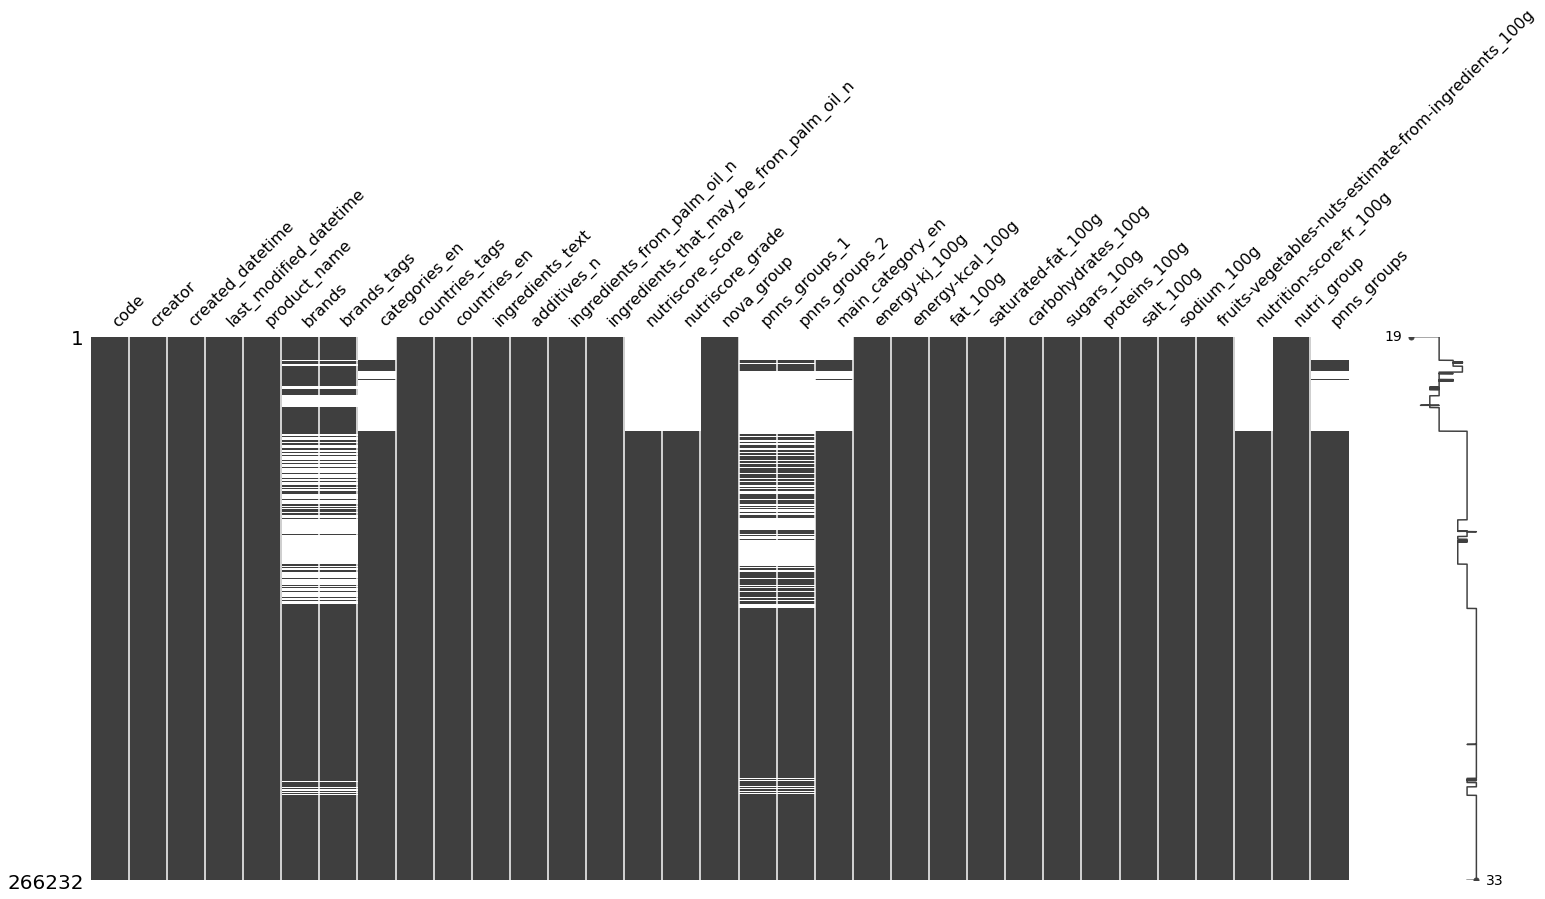

In [5]:
msno.matrix(df)

<AxesSubplot:>

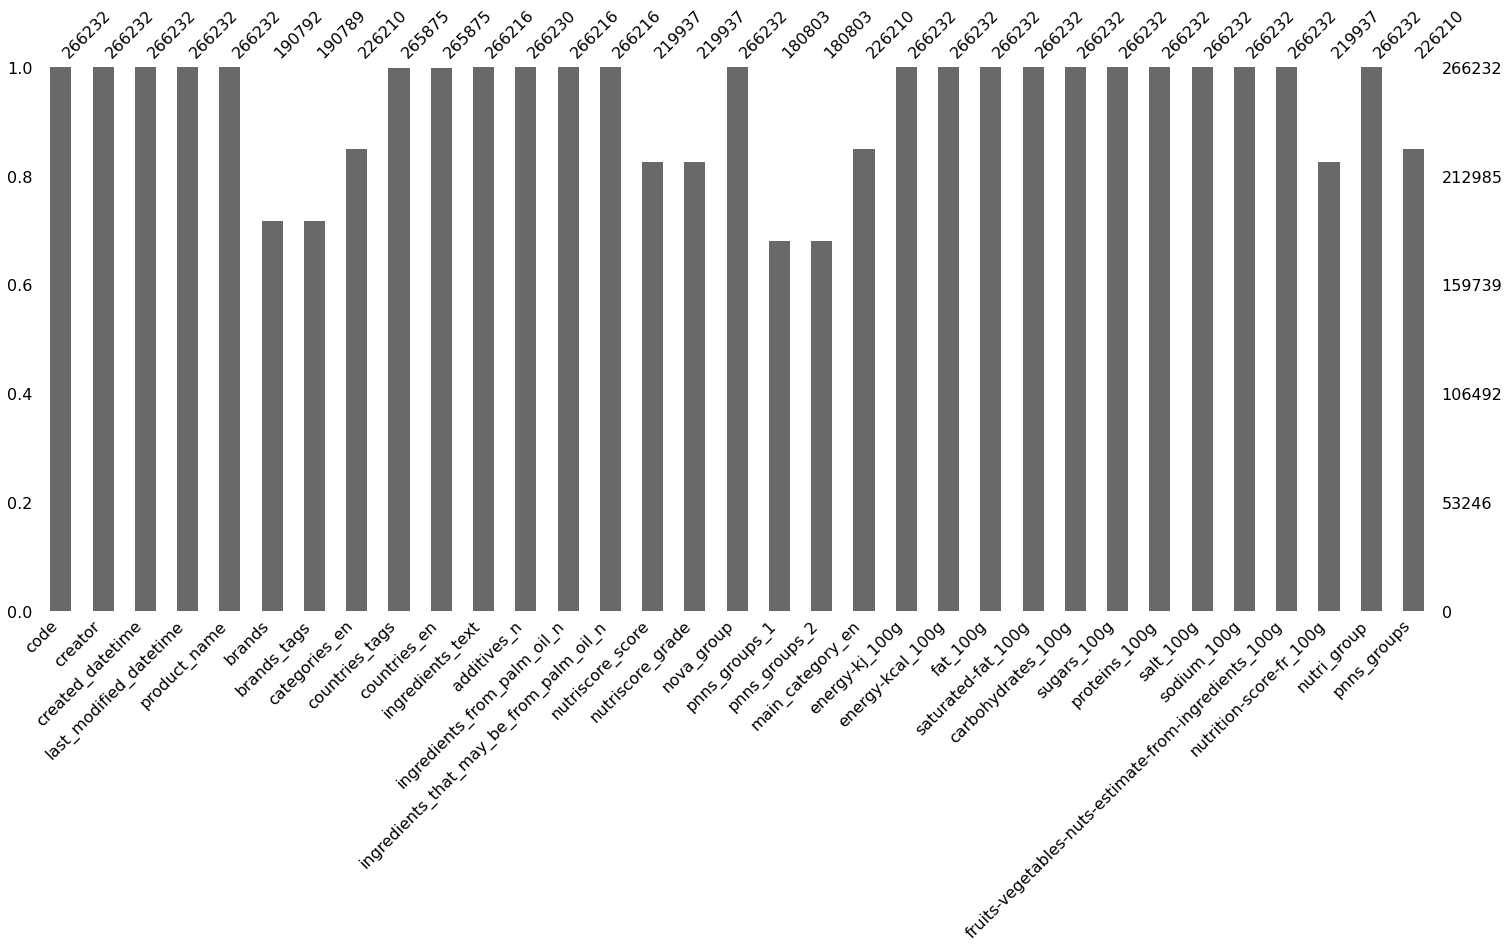

In [6]:
msno.bar(df)

<AxesSubplot:>

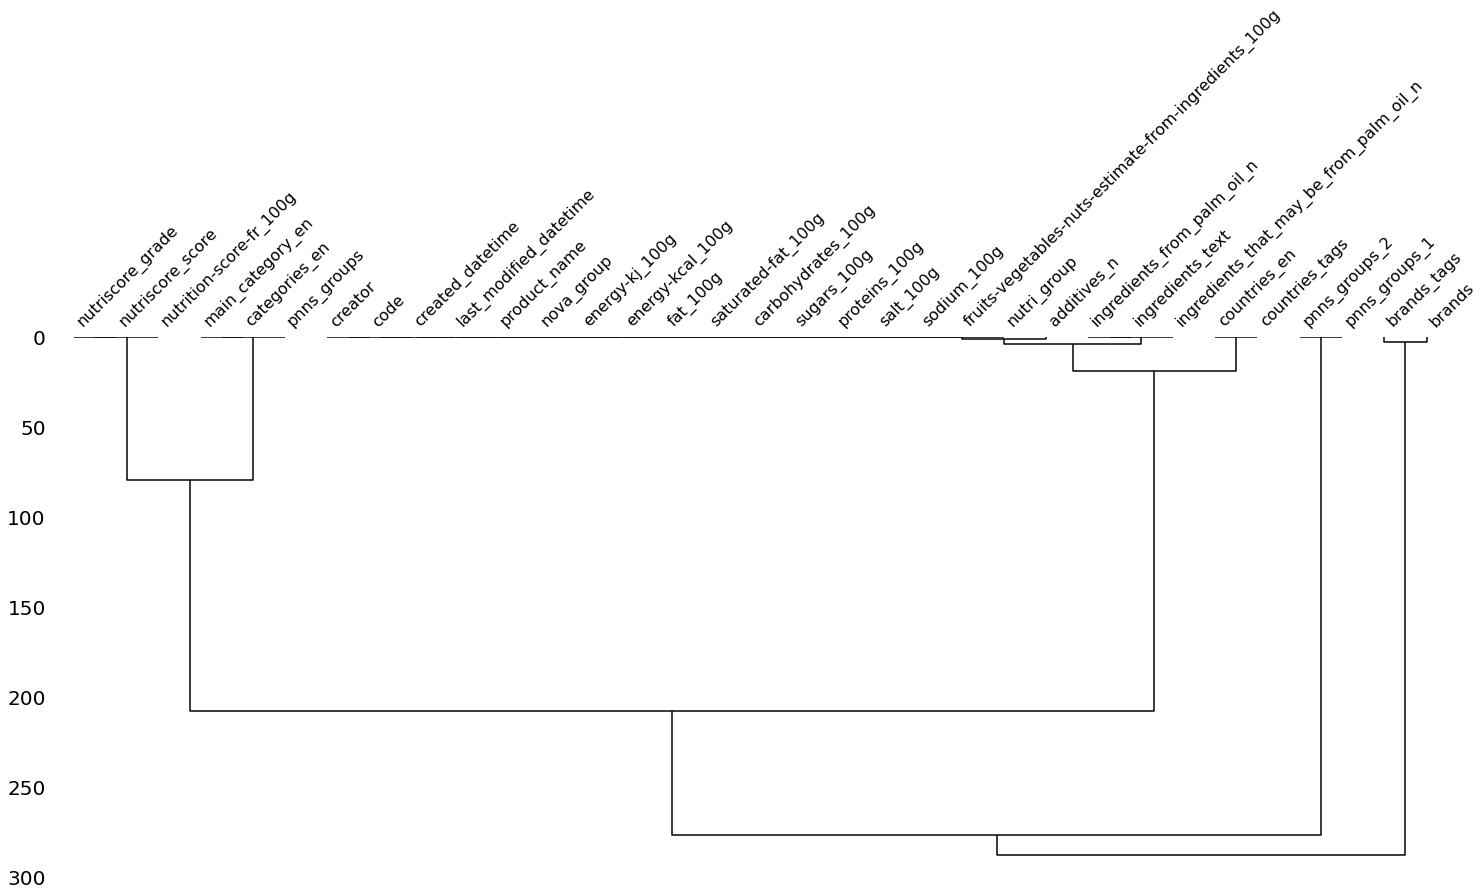

In [7]:
msno.dendrogram(df)

Il s'agit bien d'un fichier nettoyé, nous pouvons donc faire l'analyse

-----------------------------------------------------------------------------------------------
# 2. Analyse des données

> * Réalisez une analyse exploratoire de données : https://openclassrooms.com/fr/courses/4525281-realisez-une-analyse-exploratoire-de-donnees

> * Graphique : https://www.psiweb.org/docs/default-source/2018-psi-conference-posters/48-julie-jones.pdf
> * Missingno : https://github.com/ResidentMario/missingno    
    
> Tout au long de l’analyse, produire des visualisations afin de mieux comprendre les données. Effectuer une analyse univariée pour chaque variable intéressante, afin de synthétiser son comportement.
> (**L’appel à projets spécifie que l’analyse doit être simple à comprendre pour un public néophyte. Soyez donc attentif à la lisibilité : taille des textes, choix des couleurs, netteté suffisante, et variez les graphiques (boxplots, histogrammes, diagrammes circulaires, nuages de points…) pour illustrer au mieux votre propos.**)

## 2.1. Graphe de corrélations entre les variables

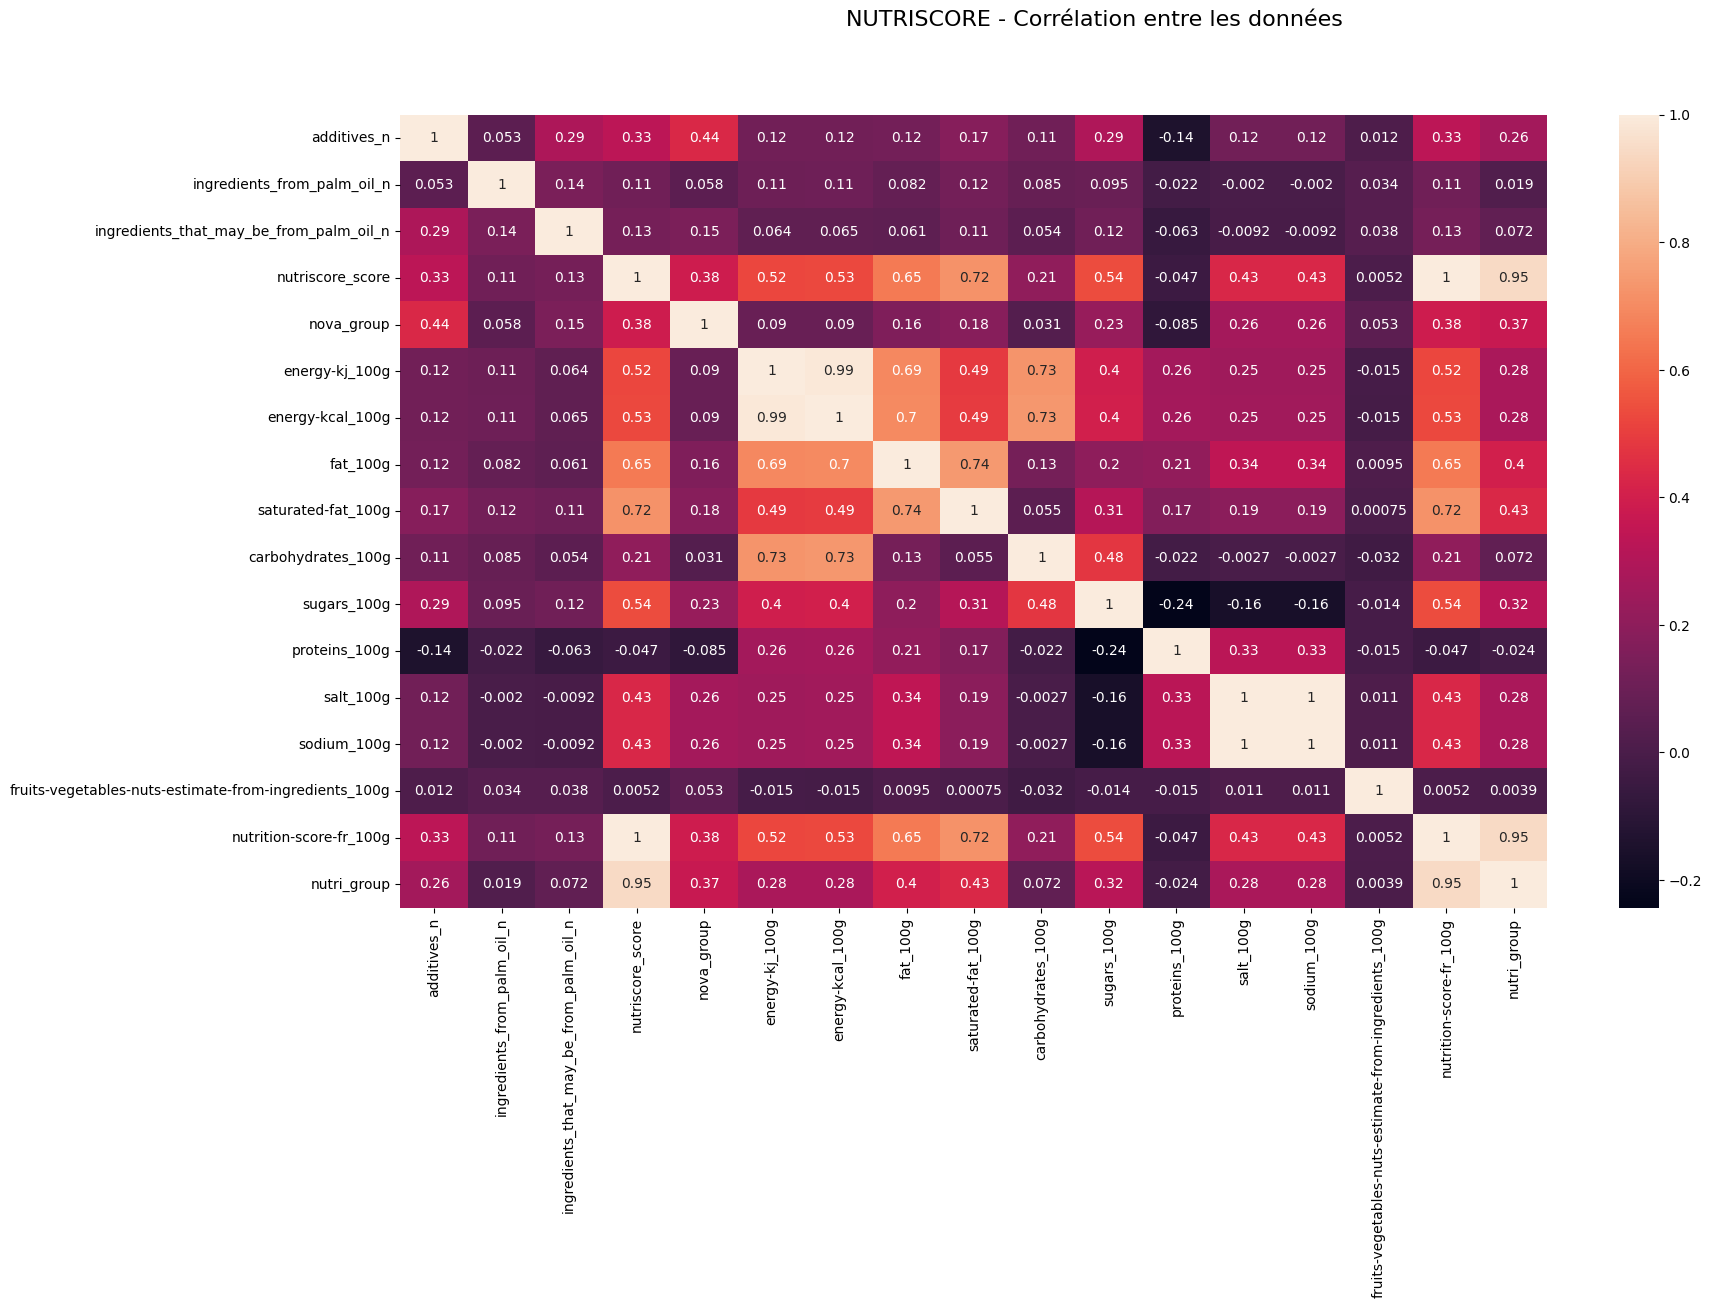

In [8]:
va_data.draw_correlation_graphe(df, verbose)

**2.1.  Analyse des corrélations - Commentaires**

* Les satured fat sont intégrées dans fat d'où la corrélation à 0.74
* Les sucres font partie des carbohydrates
  * `Les sucres (carbohyrates) se divisent en carbohydrates simples et carbohydrates complexes`
  * Pour autant la corrélation est de 0.48 seulement, il y a donc certainement d'autres facteurs
* L'énergie a 2 mesures : Kcal et KJ et une formule existe pour convertir la valeur de l'un à l'autre, il est donc possible de ne garder qu'une seule de ces 2 colonnes     


*Nutriscore* : Nous remarquons par rapport à cette heatmap que le nutriscore est fortement lié à :

| Coef. | Colonne       |
| ----- | ------------- |
| 0.72  | Satured Fat   |
| 0.65  | Fat           |
| 0.54  | sugar         |
| 0.53  | energy        |
| 0.43  | salt          |

*Nova group* est fortement lié à :

| Coef. | Colonne       |
| ----- | ------------- |
| 0.44  | nb additifs   |


<mark>Par rapport à notre application nous pouvons déjà noté que si nous souhaitons un produit avec un meilleur nutriscore que nos concurrents nous pouvons jouer sur les quantités de graisse, de sucre et de sel pour avoir un meilleur nutriscore.
De même si nous visons un nova_groupe de meilleur qualité, nous devons limiter les additifs.
</mark>

## 2.2. Corrélation entre les variables

#### 2.2.1. Analyse de la corrélation entre nutriscore et nova_group

Notre intuition nous dit que le nutriscore et le nova_group ont une corrélation, et pourtant la matrice de corrélations précédente, indique qu'elle est seulement de 0.38, donc il n'y aurait pas de corrélation forte entre ces deux notions.

Nous allons revenir aux données pour pousser cette analyse et voir s'il y a quand même un lien entre ces 2 notations.

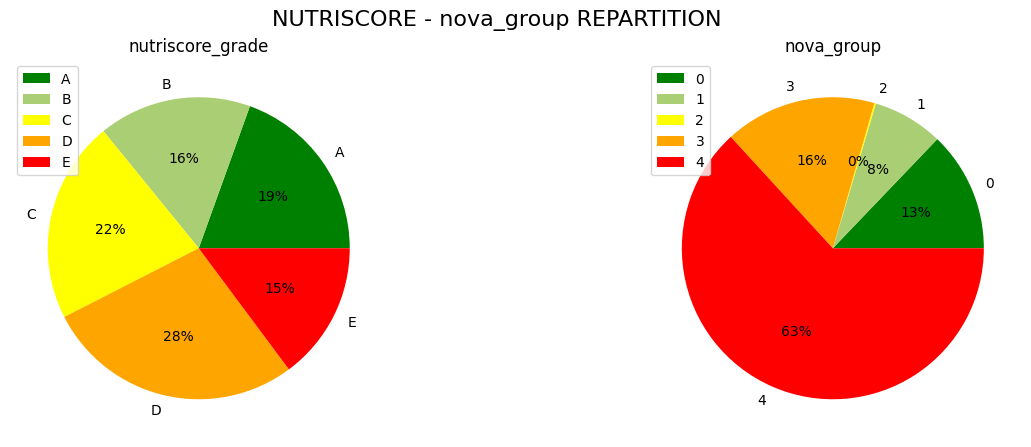

draw_pie nova_group  ................................................. END


In [9]:
va_data.draw_pie_multiple(df, ['nutriscore_grade', 'nova_group'], verbose=verbose)

Sur le camembert représentant le nova_group, la valeur 0 représente l'absence de valeur et non un code nova_group.    
Il y a donc 13% de nos données qui n'ont pas de nova_group identifié    
L'objectif de ces deux graphes étaient :
1. de représenter la répartition des scores sur notre base de produit
1. de comparer les proportions des deux notations (nutriscore et nova_group)

Afin de mieux comparer ces deux notations, nous allons réduire les données à celles qui ont un nova groupe identifié

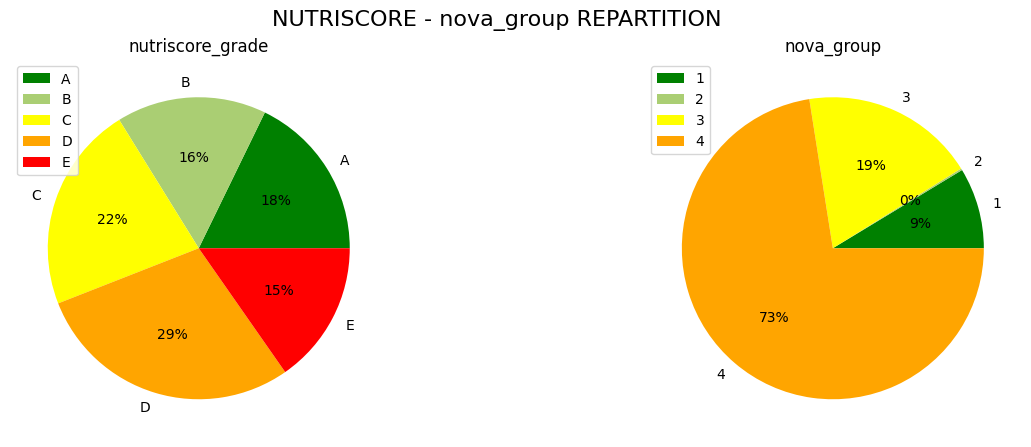

draw_pie nova_group  ................................................. END


In [10]:
va_data.draw_pie_multiple(df[df['nova_group']>0], ['nutriscore_grade', 'nova_group'], verbose=verbose)

Avec cette nouvelle représentation, il reste difficile de voir s'il y a un lien entre les deux notations, nous allons donc les comparer par valeurs de l'un et l'autre, toujours sur les données qui ont été évaluées (donc >0)

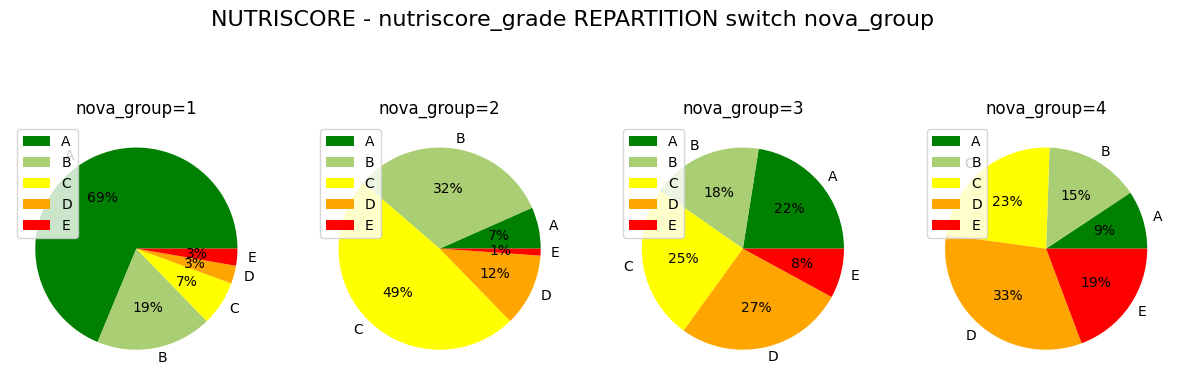

draw_pie nova_group  ................................................. END


In [11]:
va_data.draw_pie_multiple_by_value(df[df['nova_group']>0],'nova_group', [1,2,3,4], 'nutriscore_grade', verbose=verbose)

Nous pouvons constater que pour le nova_group 1 a une part plus importante de nutriscore A.
Le nutriscore A concerne beaucoup les fruits et légumes qui ne sont pas transformés et rentrent donc la catégorie nutri_score 1.

Par contre pour les autres nova_group il est plus difficile de voir un lien clair.

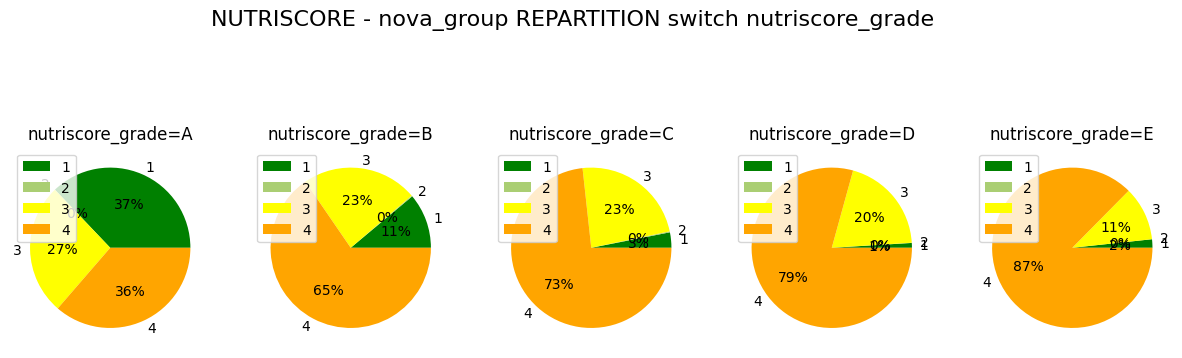

draw_pie nutriscore_grade  ................................................. END


In [12]:
va_data.draw_pie_multiple_by_value(df[df['nova_group']>0],'nutriscore_grade', ["A", "B", "C", "D", "E"], 'nova_group', verbose=verbose)

Dans l'approche inverse, le nutriscore E semble être principalement lié au nova_group 4, ce qui semble logique, le nova_group 4 porte sur les produits préparés avec beaucoup d'additifs.    
En résumé, entre le nova_group et le nutriscore, hors les deux extrêmes de ces catégories, il n'est pas possible de les lier "simplement".

<mark>Par rapport à notre application, nous allons nous concentrer sur le nutriscore en priorité</mark>

### 2.2.2. Analyse des catégories de produits

Pour notre application nous devons creuser l'analyse sur les différentes catégories de produit

In [13]:
df['pnns_groups'].describe()

count                 226210
unique                  3373
top       Biscuits and cakes
freq                   26555
Name: pnns_groups, dtype: object

Il y a trop de catégories, il faut prendre le top

#### 2.2.2.1. Nombre de produits par catégorie

In [14]:
df['pnns_groups'].value_counts().head(20)

Biscuits and cakes        26555
Cereals                   19351
One-dish meals            13387
Milk and yogurt           13346
Snacks                    13006
Bread                     11339
Dressings and sauces      11330
Processed meat             9744
Fish and seafood           8412
Frozen desserts            8322
Cheese                     7348
Sweetened beverages        6488
Frozen foods               6288
Meat                       6034
Vegetables                 5182
Sweets                     4536
Unsweetened beverages      4269
Appetizers                 3638
Legumes                    3458
Pizza pies and quiches     3165
Name: pnns_groups, dtype: int64

In [15]:
data_pnns_groups = df['pnns_groups'].value_counts()
data_pnns_groups = data_pnns_groups[data_pnns_groups>600]
data_pnns_groups.shape

(39,)

In [16]:
data_pnns_groups.describe()

count       39.000000
mean      5426.102564
std       5781.356842
min        620.000000
25%       1139.500000
50%       3165.000000
75%       7835.000000
max      26555.000000
Name: pnns_groups, dtype: float64

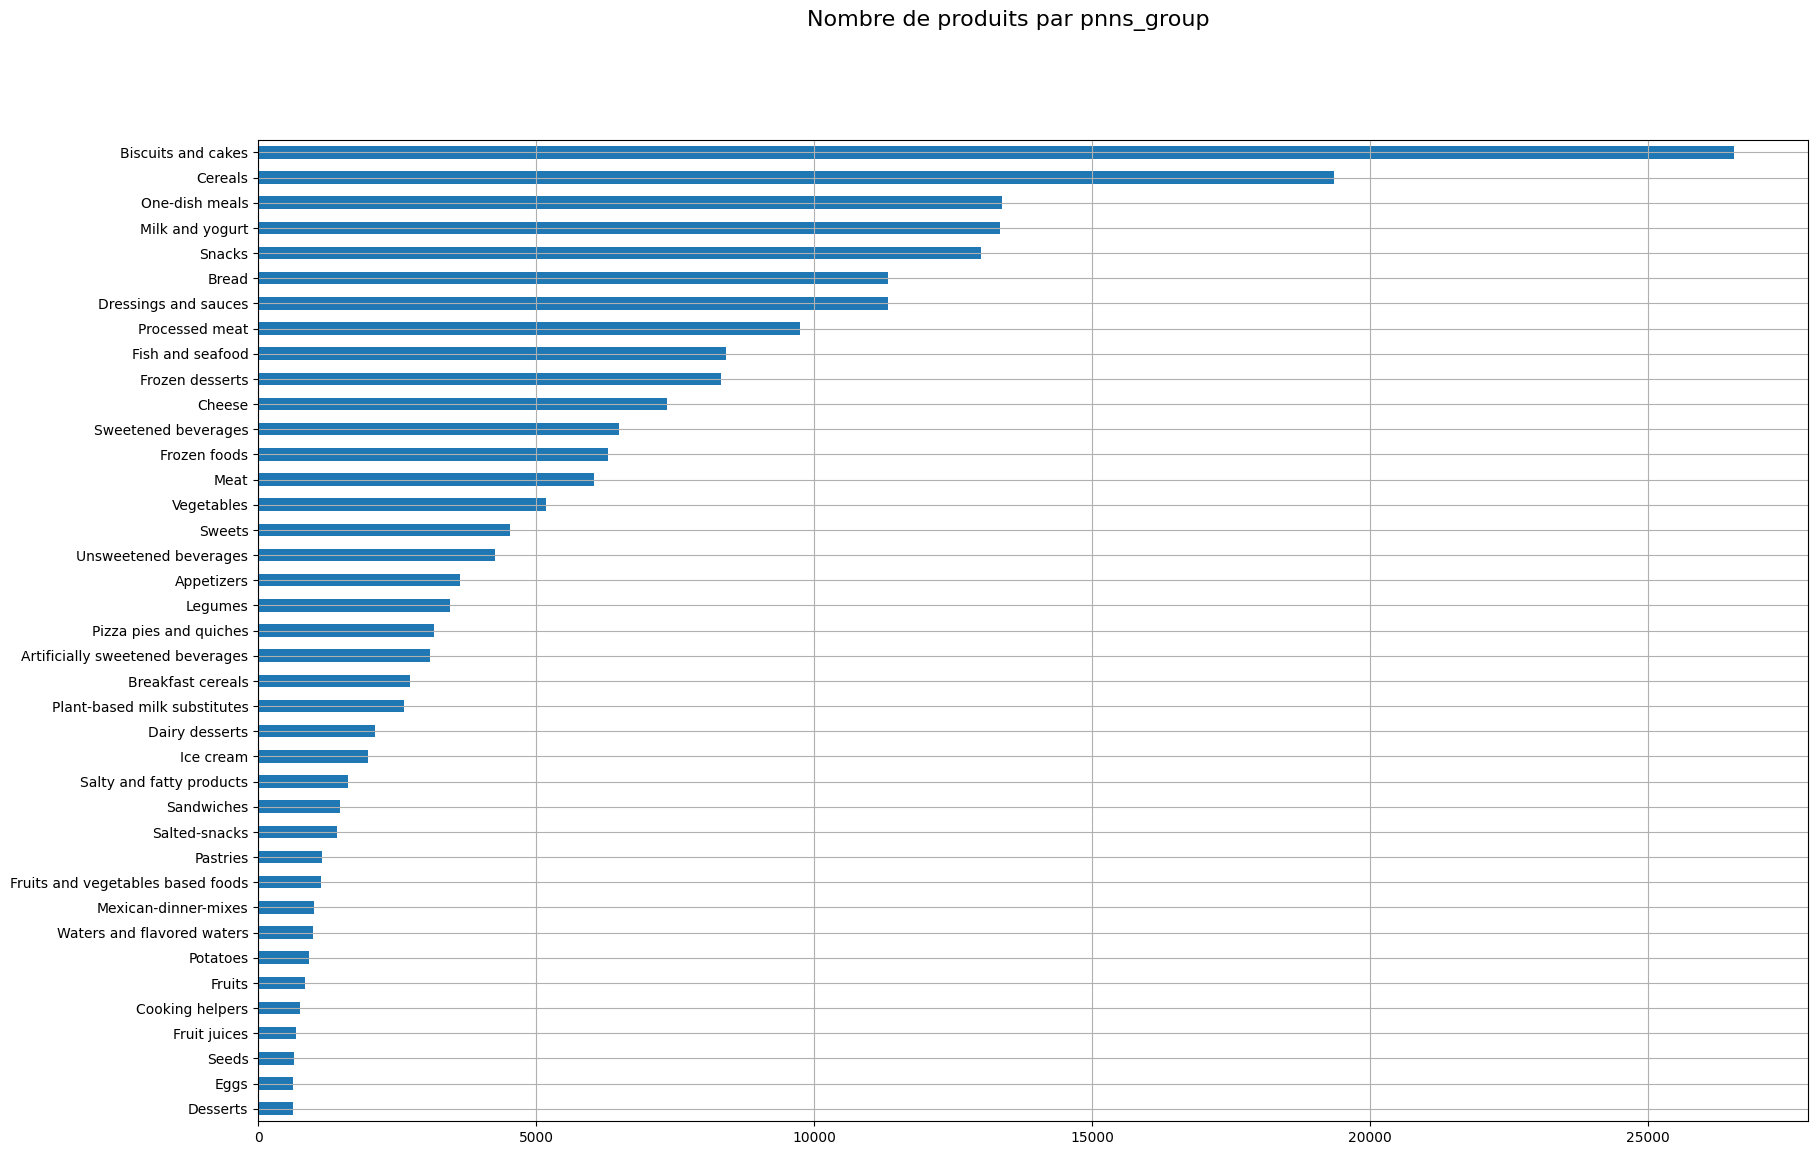

In [17]:
figure, axe = plt.subplots(1,1)
data_pnns_groups.sort_values(ascending=True).plot(kind='barh')
taille = data_pnns_groups.shape[0]//3
figure.set_size_inches(20, taille, forward=True)
axe.set_facecolor(va_data.PLOT_BAGROUNG_COLOR)
figure.patch.set_facecolor(va_data.PLOT_FIGURE_BAGROUNG_COLOR)
figure.set_dpi(100)
figure.suptitle("Nombre de produits par pnns_group", fontsize=16)
plt.grid()
plt.show()

<mark>Nous cherchons une catégorie de produit qui n'est pas trop représentée mais un minimum présente quand même.
Par exemple en dessous de 5 000 produits.</mark>

| Catégorie             | Commentaire                                                           |
| --------------------- | --------------------------------------------------------------------- |
| Sweet                 | difficile d'améliorer le nutriscore car très sucré                    |
| Unsweetened beverages | difficile aussi d'améliorer le nutriscore                             |
| Appetizers            | lié à certaines cultures, attention au développement international    |
| Legumes               | Trop périssable, pas d'amélioration nutriscore possible               |
| Pizza ...             | Nécessite de chauffer le produit, périssable rapidement               |
| Artificially sweetened| Pas de boisson                                                        |
| Breakfast cereals     | Rejoint la catégorie Cereals qui est en tête de classement            |
| Plant milk...         | Trop périssable, nécessite un réfrigérateur, ...                      |
| Dairy dessert         |                                                                       |
| Ice Scream            | Nécessite un congélateur, limite l'internationnalisation              |
| Salty et Fatty product| Pas très vendeur comme catégorie                                      |
| Sanwiches             | Périssable rapidement                                                 |
| <mark>Salted-snacks</mark>| Ce produit semble correspondre à nos attentes                     |

#### 2.2.2.2. Nombre de marques par catégorie

Zoom pour voir le nombre de marques différentes par catégorie de produit, ce qui nous permet d'évaluer la concurrence

In [18]:
type(data_pnns_groups)

pandas.core.series.Series

In [19]:
# création d'un DF en vu de faire un merge
data_pnns_groups_df = pd.DataFrame(data_pnns_groups, index=None, copy=True)

In [20]:
data_pnns_groups_df = data_pnns_groups_df.reset_index()
data_pnns_groups_df.index

RangeIndex(start=0, stop=39, step=1)

In [21]:
data_pnns_groups_df.columns

Index(['index', 'pnns_groups'], dtype='object')

In [22]:
data_pnns_groups_df = data_pnns_groups_df.rename(columns={"pnns_groups": "count"})
data_pnns_groups_df.head()

,index,count
0,Biscuits and cakes,26555
1,Cereals,19351
2,One-dish meals,13387
3,Milk and yogurt,13346
4,Snacks,13006


In [23]:
# renommage de la colonne
data_pnns_groups_df = data_pnns_groups_df.rename(columns={"index": "pnns_groups"})
data_pnns_groups_df.head()

,pnns_groups,count
0,Biscuits and cakes,26555
1,Cereals,19351
2,One-dish meals,13387
3,Milk and yogurt,13346
4,Snacks,13006


In [24]:
# merge sur le pnns_group, l'objectif du merge est ensuite de sélectionner les produits qui font partit du top
df_na_top_pnns_group = df.merge(data_pnns_groups_df, on="pnns_groups", how='left', indicator=True)
df_na_top_pnns_group.shape

(266232, 35)

In [25]:
df_na_top_pnns_group.head()

,code,creator,created_datetime,last_modified_datetime,product_name,brands,brands_tags,categories_en,countries_tags,countries_en,...,sugars_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g,nutri_group,pnns_groups,count,_merge
0,4058172761478,kiliweb,2021-03-24 12:24:41+00:00,2021-10-09 08:17:12+00:00,hafer cappuccino dm,NaN,NaN,NaN,en:germany,Germany,...,12.0,2.3,0.250,0.10,0.0,NaN,0,NaN,NaN,left_only
1,5060088701126,kiliweb,2017-12-31 11:52:49+00:00,2017-12-31 11:53:03+00:00,Nakd Nibble Bar - Berry Cheeky,Nakd,nakd,NaN,en:france,France,...,12.5,2.2,0.100,0.04,0.0,NaN,0,NaN,NaN,left_only
2,4099200029139,waistline-app,2018-11-08 20:02:13+00:00,2021-02-01 11:33:45+00:00,Magertopfen,milfina,milfina,NaN,en:austria,Austria,...,4.1,13.5,0.100,0.04,0.0,NaN,0,NaN,NaN,left_only
3,0021000615315,kiliweb,2018-03-08 18:49:04+00:00,2021-06-07 22:46:57+00:00,Kraft Parmesan Cheese Grated,Kraft,kraft,NaN,en:france,France,...,0.0,2.0,1.000,0.40,0.0,NaN,0,NaN,NaN,left_only
4,3760003430019,kiliweb,2018-01-07 12:15:52+00:00,2020-04-08 07:00:19+00:00,"Crêpes Faites Mains, x12",Crepes Bretonnes,crepes-bretonnes,NaN,en:france,France,...,28.3,8.7,1.575,0.63,0.0,NaN,0,NaN,NaN,left_only


In [26]:
df_na_top_pnns_group.shape

(266232, 35)

In [27]:
# on sélectionne uniquement les produits du top, donc qui sont "both"
df_na_top_pnns_group = df_na_top_pnns_group[df_na_top_pnns_group["_merge"]=="both"]
df_na_top_pnns_group.shape

(211618, 35)

In [28]:
# on supprime les colonnes du merge, qui ne sont plus nécessaires
df_na_top_pnns_group = df_na_top_pnns_group.drop('_merge', axis=1)
df_na_top_pnns_group = df_na_top_pnns_group.drop('count', axis=1)
df_na_top_pnns_group.head()

,code,creator,created_datetime,last_modified_datetime,product_name,brands,brands_tags,categories_en,countries_tags,countries_en,...,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g,nutri_group,pnns_groups
11579,0883712000526,org-database-usda,2020-04-23 11:59:33+00:00,2020-04-23 11:59:33+00:00,Wild flour bakehouse pancake mix,NaN,NaN,"Biscuits and cakes,Cooking helpers,Cakes,Desse...",en:united-states,United States,...,0.43,65.96,14.89,17.02,1.7025,0.681,0.0,NaN,0,Biscuits and cakes
11580,07203698279,org-database-usda,2020-04-23 20:27:41+00:00,2020-04-23 20:27:42+00:00,Deluxe chocolate chip cookie mix,NaN,NaN,"Biscuits and cakes,Cooking helpers,Cakes,Desse...",en:united-states,United States,...,4.55,77.27,45.45,4.55,0.9100,0.364,0.0,NaN,0,Biscuits and cakes
11581,0643392500156,org-database-usda,2020-04-23 15:15:29+00:00,2020-04-23 15:15:29+00:00,Natural cocoa powder,NaN,NaN,"Beverages,Dried products,Dried products to be ...",en:united-states,United States,...,10.00,40.00,0.00,20.00,0.0000,0.000,0.0,NaN,0,Unsweetened beverages
11582,0071740310223,org-database-usda,2020-04-23 19:31:45+00:00,2020-04-23 19:31:45+00:00,Self-rising flour,NaN,NaN,"Biscuits and cakes,Cooking helpers,Cakes,Desse...",en:united-states,United States,...,0.00,73.33,3.33,6.67,2.8325,1.133,0.0,NaN,0,Biscuits and cakes
11584,0856346006004,org-database-usda,2020-04-23 16:00:53+00:00,2020-04-23 16:00:53+00:00,Almond flour baking blend,NaN,NaN,"Biscuits and cakes,Cooking helpers,Cakes,Desse...",en:united-states,United States,...,0.00,50.00,0.00,8.33,1.5625,0.625,0.0,NaN,0,Biscuits and cakes


In [29]:
# on récupère les colonnes qui nous intéressent uniquement
df_na_top_pnns_group_light = df_na_top_pnns_group[['pnns_groups', 'brands']]
df_na_top_pnns_group_light.shape

(211618, 2)

In [30]:
df_na_top_pnns_group_light.head()

,pnns_groups,brands
11579,Biscuits and cakes,NaN
11580,Biscuits and cakes,NaN
11581,Unsweetened beverages,NaN
11582,Biscuits and cakes,NaN
11584,Biscuits and cakes,NaN


In [31]:
# on supprime les lignes NA sur la brand
df_na_top_pnns_group_light_na = df_na_top_pnns_group_light.dropna(axis=0)
df_na_top_pnns_group_light_na.shape

(144826, 2)

In [32]:
df_na_top_pnns_group_light_na.head()

,pnns_groups,brands
11607,Unsweetened beverages,U
11678,Unsweetened beverages,U
11685,Sweetened beverages,Green & Black’s
11700,Sweetened beverages,Quai Sud
11730,Unsweetened beverages,"U Bio,U"


In [33]:
df_na_top_pnns_group_light_na.dtypes

pnns_groups    category
brands           object
dtype: object

In [34]:
df_na_top_pnns_group_light_na['pnns_groups'] = df_na_top_pnns_group_light_na['pnns_groups'].astype("object")
df_na_top_pnns_group_light_na.dtypes

C:\Users\User\AppData\Local\Temp/ipykernel_16208/1414562514.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_na_top_pnns_group_light_na['pnns_groups'] = df_na_top_pnns_group_light_na['pnns_groups'].astype("object")


pnns_groups    object
brands         object
dtype: object

In [35]:
# Nous obtenons le nombre de produit par brand par catégorie
d_group = df_na_top_pnns_group_light_na.groupby('pnns_groups')['brands'].value_counts()
d_group

pnns_groups                 brands          
Appetizers                  Lay's               101
                            Pringles            101
                            Bret's               72
                            Auchan               71
                            Carrefour            47
                                               ... 
Waters and flavored waters  évian                 1
                            Горна Баня            1
                            נביעות                1
                            เปอริเอ้,Perrier      1
                            可口可乐                  1
Name: brands, Length: 57231, dtype: int64

In [36]:
d_group = d_group.rename("nb_product_bybrands_by_pnns_group")
d_group

pnns_groups                 brands          
Appetizers                  Lay's               101
                            Pringles            101
                            Bret's               72
                            Auchan               71
                            Carrefour            47
                                               ... 
Waters and flavored waters  évian                 1
                            Горна Баня            1
                            נביעות                1
                            เปอริเอ้,Perrier      1
                            可口可乐                  1
Name: nb_product_bybrands_by_pnns_group, Length: 57231, dtype: int64

In [37]:
d_group = d_group.reset_index()
d_group

,pnns_groups,brands,nb_product_bybrands_by_pnns_group
0,Appetizers,Lay's,101
1,Appetizers,Pringles,101
2,Appetizers,Bret's,72
3,Appetizers,Auchan,71
4,Appetizers,Carrefour,47
...,...,...,...
57226,Waters and flavored waters,évian,1
57227,Waters and flavored waters,Горна Баня,1
57228,Waters and flavored waters,נביעות,1
57229,Waters and flavored waters,"เปอริเอ้,Perrier",1


In [38]:
# Il nous reste à compter le nombre de fois que le pnns_group est présent pour connaître le nombre de brand différentes
nb_brand_by_pnns_group = d_group['pnns_groups'].value_counts()
nb_brand_by_pnns_group

Biscuits and cakes                   6030
Cereals                              4439
One-dish meals                       3532
Dressings and sauces                 3174
Milk and yogurt                      2887
Bread                                2840
Processed meat                       2642
Sweetened beverages                  2441
Cheese                               2393
Fish and seafood                     2339
Snacks                               2121
Sweets                               1861
Unsweetened beverages                1791
Meat                                 1779
Appetizers                           1503
Vegetables                           1473
Legumes                              1137
Breakfast cereals                    1084
Artificially sweetened beverages     1043
Frozen foods                         1023
Salty and fatty products              974
Frozen desserts                       859
Plant-based milk substitutes          852
Dairy desserts                    

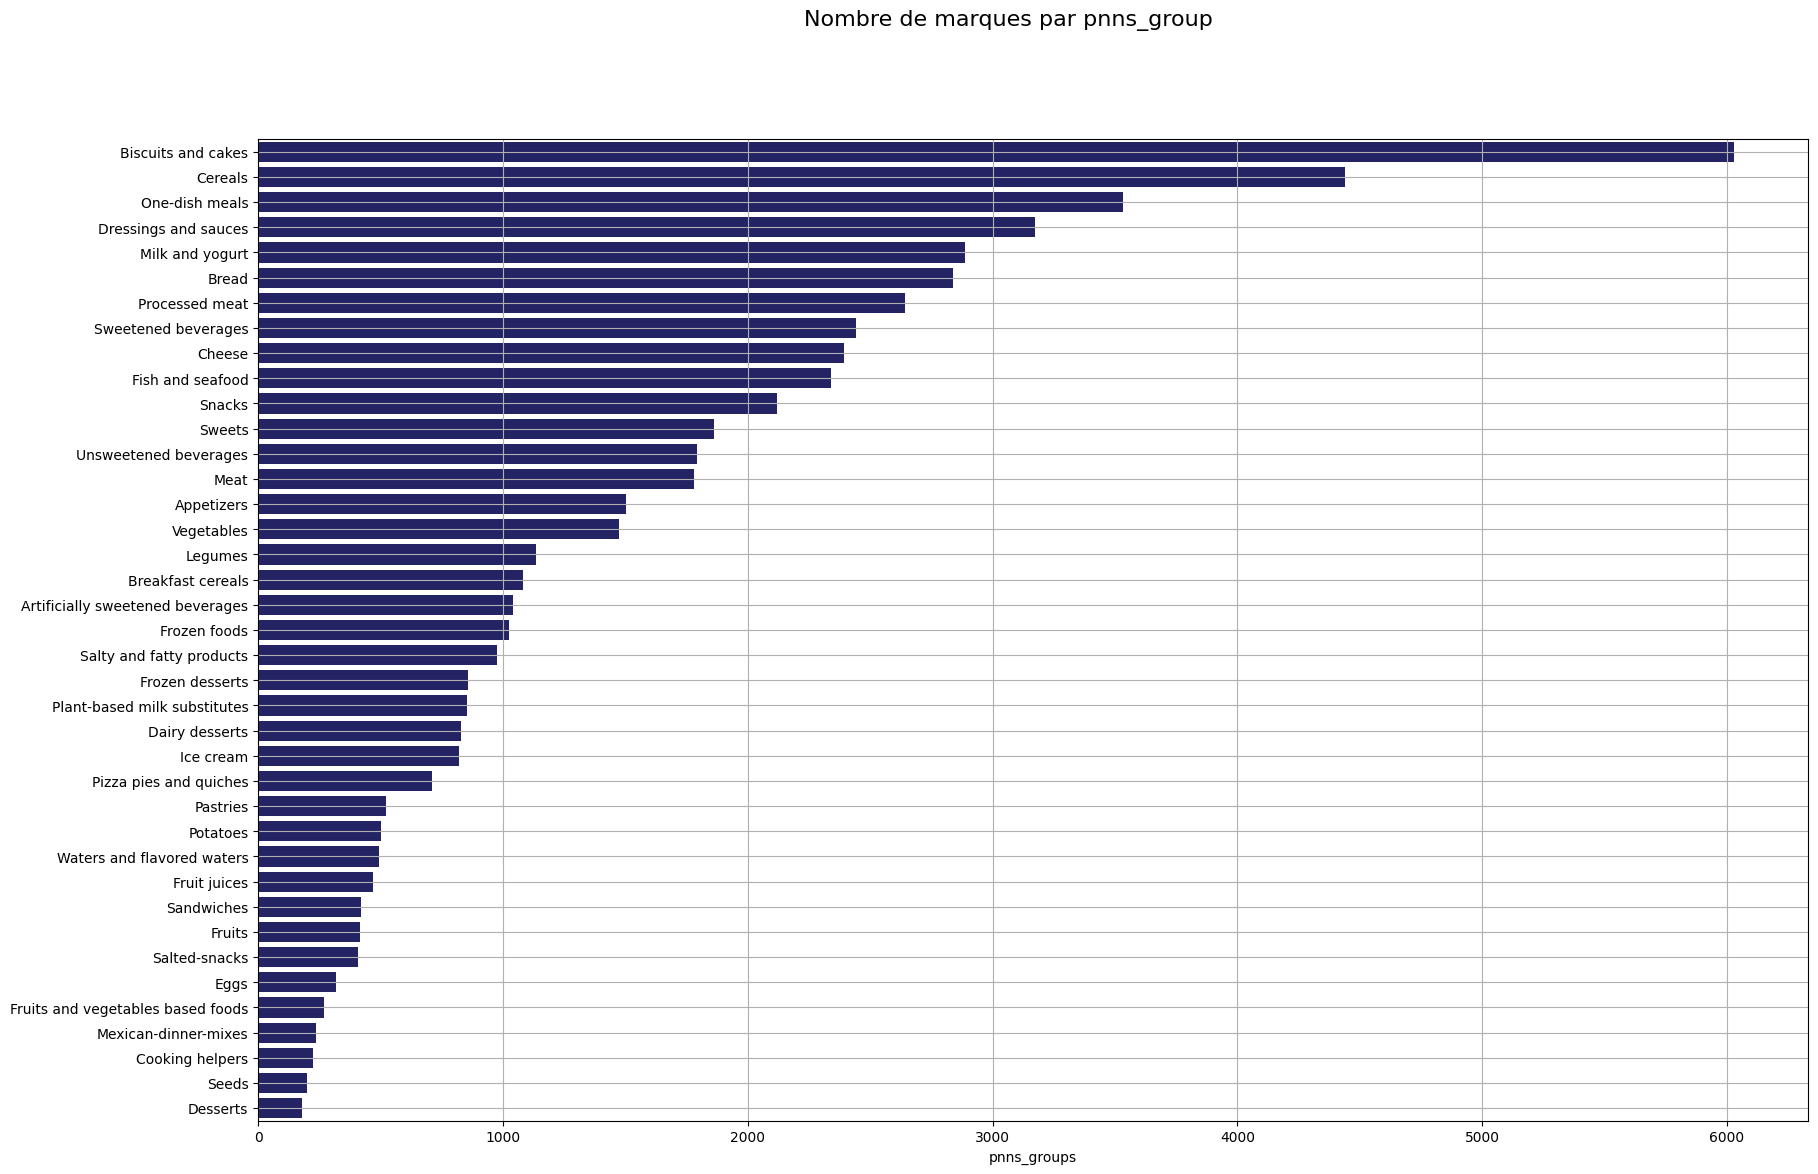

In [39]:
figure, axes = plt.subplots(1,1)
g = sns.barplot(x=nb_brand_by_pnns_group, y=nb_brand_by_pnns_group.index, color="midnightblue")
axes.set_facecolor(va_data.PLOT_BAGROUNG_COLOR)
figure.patch.set_facecolor(va_data.PLOT_FIGURE_BAGROUNG_COLOR)
figure.set_size_inches(20, (nb_brand_by_pnns_group.shape[0]//3), forward=True)
figure.set_dpi(100)
figure.suptitle("Nombre de marques par pnns_group", fontsize=16)
plt.grid()
plt.show()

Ce graphe nous permet d'identifier les produits déjà prisés par beaucoup de marques.    
<mark>Afin d'améliorer nos chances de déployer notre produit, nous devons être attentif au marché et aux concurrents</mark>

* Faut-il viser un produit avec moins de marques => voir si ces marques sont des références sur ce produit et donc difficile de percer (par exemple Coca-cola, ...)
* Faut-il viser un produit avec beaucoup de marques, au risque d'être noyer sous la concurrence
* Faut-il pousser l'analyse par pays pour voir si les marques sont implantées dans tous les pays

Nous cherchons une catégorie de produit qui n'a pas trop de marques mais pas de lobby non plus.
Par exemple en dessous de 1 000 marques. Si on reprend le tableau de la liste des catégories :


| Catégorie             | Status Nb product  |  Commentaire                                                 |
| --------------------- | ------------------ |------------------------------------------------------------- |
| Sweet                 | KO                 |                                                              |
| Unsweetened beverages | KO                 |                                                              |
| Appetizers            | KO                 |                                                              |
| Legumes               | KO                 |                                                              |
| Pizza ...             | KO                 |                                                              |
| Artificially sweetened| KO                 |                                                              |
| Breakfast cereals     | KO                 |                                                              |
| Plant milk...         | KO                 |                                                              |
| Dairy dessert         | KO                 |                                                              |
| Ice Scream            | KO                 |                                                              |
| Salty et Fatty product| KO                 |                                                              |
| Sanwiches             | KO                 |                                                              |
| <mark>Salted-snacks</mark>| OK             | OK                                                           |
| Pastries              | NONE               |                                                              |
| Potatoes              | NONE               |                                                              |
| Waters & flavored     | NONE               | Difficile d'améliorer le nutriscore                          |
| Fruits juice          | NONE               | Conservation au frais ?, Difficile d'améliorer le nutriscore |
| Fruits                | NONE               | Trop périssable                                              |
| Eggs                  | NONE               | Trop fragile                                                 |


#### 2.2.2.3. Zoom sur notre catégorie de produit cible

Nous avons repéré les snacks salés.

#### 2.2.2.3.1. Zoom sur notre catégorie de produit cible => Concurrents
il faut vérifier les concurrents pour ce produit en particulier

In [40]:
selected_pnns_group = "Salted-snacks"
# Nombre de produits par marques pour une catégorie de produit que nous ciblons
salted_snack_light = df_na_top_pnns_group[df_na_top_pnns_group["pnns_groups"] == selected_pnns_group]
salted_snack_light = salted_snack_light[['brands', 'countries_en']]
print(salted_snack_light.shape)
salted_snack_light.head()


(1415, 2)


,brands,countries_en
46615,Asturi,United States
46634,Oregon Brineworks,United States
47001,Taste Elevated,United States
47177,Reser's Fine Foods,United States
47201,Reser's Fine Foods,United States


In [41]:
salted_snack_light['brands'].value_counts().head(20)

Mezzetta                                    17
Victoria                                    14
Meijer                                      12
Divina                                      11
Goya                                        10
Lindsay                                      9
Sun Of Italy                                 9
Delallo                                      9
Signature Cafe                               8
Mancini                                      8
Roland                                       8
Reser's Fine Foods                           8
Signature                                    7
Musco Family Olive Co.                       7
Kroger                                       7
Cento                                        7
Signature Kitchens                           7
Bell-View                                    6
Whole Foods Market,  Bread & Circus Inc.     6
Etai's                                       6
Name: brands, dtype: int64

In [42]:
salted_snack_light['brands'].value_counts().describe()

count    407.000000
mean       1.884521
std        1.929530
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       17.000000
Name: brands, dtype: float64

#### 2.2.2.3.2. Zoom sur notre catégorie de produit cible => Pays

In [43]:
salted_snack_light['countries_en'].value_counts()

United States                            1399
France,United States                        7
Germany,United States                       3
United States,En                            1
Italy,United States                         1
Australia,United States                     1
France,French Polynesia,United States       1
Morocco,United States                       1
Canada,United States                        1
Name: countries_en, dtype: int64

In [44]:
# Nous devons identifier les pays cette catégorie de produit de manière unique
ser_count=pd.Series(", ".join(salted_snack_light['countries_en'].dropna()).split(","))
df_country = pd.DataFrame([ser_count])
df_country = df_country.transpose()
df_country = df_country.rename(columns={0: "country"})
df_country[ "country"] = df_country[ "country"].str.strip()
df_country.value_counts()

country         
United States       1415
France                 8
Germany                3
Australia              1
Canada                 1
En                     1
French Polynesia       1
Italy                  1
Morocco                1
dtype: int64

In [45]:
def display(salted_snack_light, selected_country):
    salted_snack_light_FR = salted_snack_light[salted_snack_light['countries_en'].str.contains(selected_country)]
    print(salted_snack_light_FR.shape)
    print(salted_snack_light_FR.value_counts())

In [46]:
display(salted_snack_light, "France")

(8, 2)
brands    countries_en                         
Heinz     France,United States                     4
King's    France,French Polynesia,United States    1
Oloves    France,United States                     1
Rioverde  France,United States                     1
dtype: int64


In [47]:
display(salted_snack_light, "Italy")

(1, 2)
brands         countries_en       
Tuttocalabria  Italy,United States    1
dtype: int64


In [48]:
display(salted_snack_light, "Germany")

(3, 2)
brands       countries_en         
Heinz, Bell  Germany,United States    1
La Costena   Germany,United States    1
La Costeña   Germany,United States    1
dtype: int64


#### 2.2.2.3.3. Zoom sur notre catégorie de produit cible => Conclusion
<mark>Pour les "Salted-snacks" nous voyons qu'il y a 407 marques différentes, dont une majorité au Etats Unis, ce produit est fortement présent d'ailleurs dans ce pays par contre dans les pays Européens, on constate qu'il y a un potentiel de développement et peu de marques.</mark>

## 2.3. Analyse des nutriscores et nova group par catégorie de produit

In [49]:
data_nutri = df_na_top_pnns_group
data_nutri["nutriscore_grade"] = data_nutri["nutriscore_grade"].astype("object")
data_nutri["pnns_groups"] = data_nutri["pnns_groups"].astype("object")
data_nutri.dtypes

code                                                                  object
creator                                                               object
created_datetime                                         datetime64[ns, UTC]
last_modified_datetime                                   datetime64[ns, UTC]
product_name                                                          object
brands                                                                object
brands_tags                                                           object
categories_en                                                         object
countries_tags                                                        object
countries_en                                                          object
ingredients_text                                                      object
additives_n                                                          float64
ingredients_from_palm_oil_n                                          float64

In [50]:
####################### CREATION DF PAR NUTRI-SCORE #######################
data_nutri = data_nutri.groupby(['pnns_groups', 'nutriscore_grade'])['nutriscore_grade'].count().unstack(fill_value=0)
data_nutri["sum"] = data_nutri.sum(axis=1)
data_nutri=data_nutri.sort_values(by="sum", ascending=False)
data_nutri.head()

nutriscore_grade,A,B,C,D,E,sum
pnns_groups,,,,,,
Biscuits and cakes,310,468,2539,9704,12037,25058
Cereals,10441,2265,2865,2675,887,19133
Milk and yogurt,4220,5603,2756,634,45,13258
One-dish meals,2159,3995,4362,2434,225,13175
Snacks,513,558,3244,6155,2536,13006


In [51]:
data_nutri.columns

Index(['A', 'B', 'C', 'D', 'E', 'sum'], dtype='object', name='nutriscore_grade')

In [52]:
data_nutri.index

Index(['Biscuits and cakes', 'Cereals', 'Milk and yogurt', 'One-dish meals',
       'Snacks', 'Bread', 'Dressings and sauces', 'Processed meat',
       'Fish and seafood', 'Frozen desserts', 'Cheese', 'Frozen foods',
       'Sweetened beverages', 'Meat', 'Vegetables', 'Sweets',
       'Unsweetened beverages', 'Appetizers', 'Legumes',
       'Pizza pies and quiches', 'Artificially sweetened beverages',
       'Breakfast cereals', 'Plant-based milk substitutes', 'Dairy desserts',
       'Ice cream', 'Salty and fatty products', 'Sandwiches', 'Salted-snacks',
       'Pastries', 'Fruits and vegetables based foods', 'Mexican-dinner-mixes',
       'Waters and flavored waters', 'Potatoes', 'Fruits', 'Cooking helpers',
       'Fruit juices', 'Seeds', 'Eggs', 'Desserts'],
      dtype='object', name='pnns_groups')

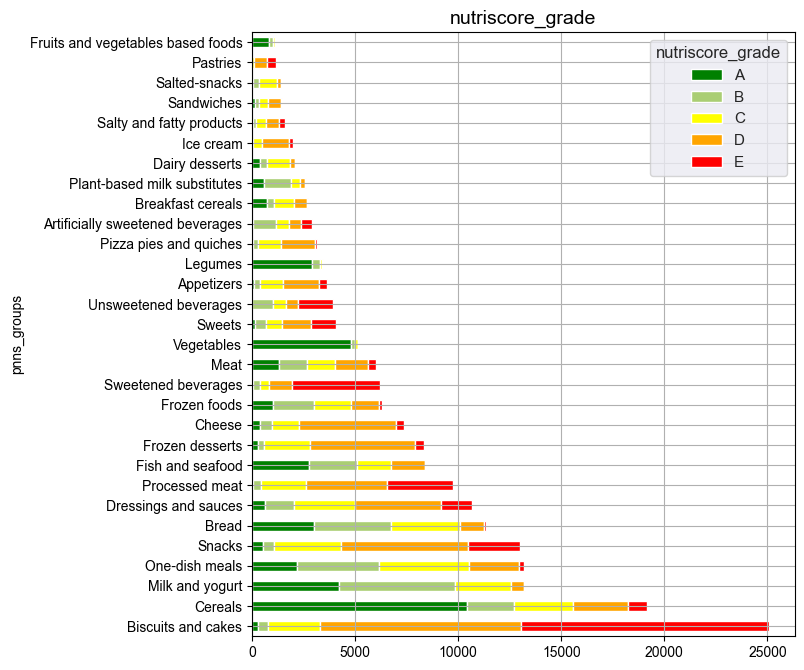

In [53]:
nb_top_pnns_groups = 30
va_data.createNutriGraph(data_nutri.head(nb_top_pnns_groups), 'nutriscore_grade', 5)

In [54]:
data_nova = df_na_top_pnns_group[df_na_top_pnns_group['nova_group']>0].groupby(['pnns_groups', 'nova_group'])['nova_group'].count().unstack(fill_value=0)
data_nova["sum"] = data_nova.sum(axis=1)
data_nova=data_nova.sort_values(by="sum", ascending=False)
data_nova.head()

nova_group,1,2,3,4,sum
pnns_groups,,,,,
Biscuits and cakes,45,1,3004,22978,26028
Cereals,7886,2,2753,6607,17248
One-dish meals,0,0,2981,9944,12925
Snacks,230,0,3381,8962,12573
Milk and yogurt,2355,1,1558,8064,11978


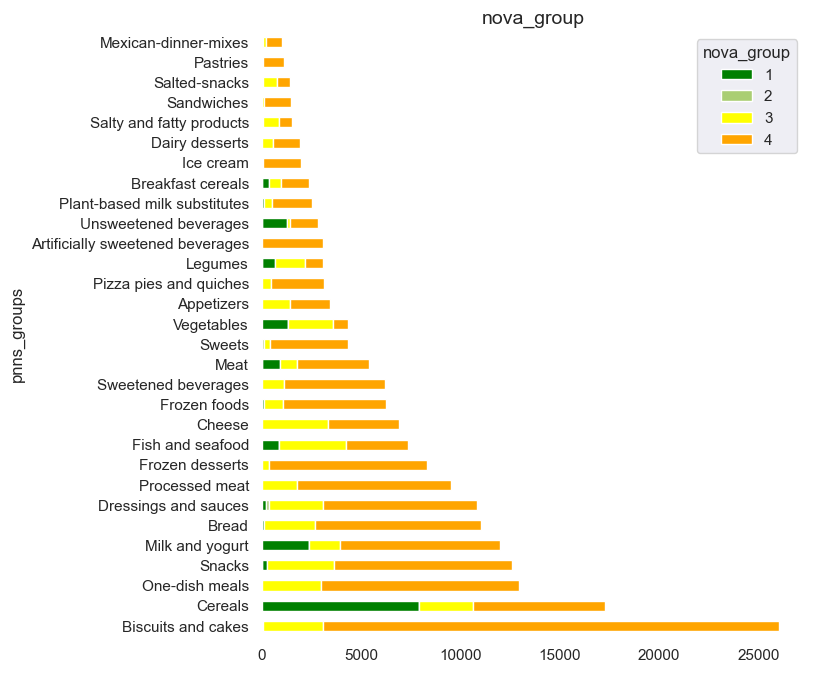

In [55]:
va_data.createNutriGraph(data_nova.head(nb_top_pnns_groups),'nova_group' , size=4)

On peut constater que certaines catégories pourraient être regroupées :
* Legumes et Fruits avec Vegetables
* ...

<mark>Pour notre application, nous constatons que nous avons effectivement une marge pour avoir un meilleur nutriscore et un meilleur nova_group que les concurrents.</mark>

### 2.3.2. Zoom sur le nutriscore des concurrents pour la catégorie cible

In [56]:
# Nombre de produits par marques pour une catégorie de produit que nous ciblons
# Données hors US
salted_snack_light_brand = df_na_top_pnns_group[(df_na_top_pnns_group["pnns_groups"] == selected_pnns_group) & (salted_snack_light['countries_en'] != "United States") & (salted_snack_light['countries_en'] != "United States,En")]
salted_snack_light_brand = salted_snack_light_brand[['countries_en', 'brands', 'nutriscore_grade']]
# Suppression des données que nous ne souhaitons pas analyser
salted_snack_light_brand["countries_en"] = salted_snack_light_brand["countries_en"].str.replace(",United States", "")
salted_snack_light_brand["countries_en"] = salted_snack_light_brand["countries_en"].str.replace(",French Polynesia", "")
salted_snack_light_brand["countries_en"] = salted_snack_light_brand["countries_en"].str.strip()
salted_snack_light_brand.dropna(inplace=True)
print(salted_snack_light_brand.shape)
salted_snack_light_brand.head()

(13, 3)


,countries_en,brands,nutriscore_grade
60417,France,Oloves,D
72136,Germany,"Heinz, Bell",C
72384,France,Heinz,D
72797,France,Heinz,C
74538,Italy,Tuttocalabria,D


In [57]:
salted_snack_light_brand_df = salted_snack_light_brand.reset_index()
print(salted_snack_light_brand_df.shape)
salted_snack_light_brand_df['countries_en'].value_counts()

(13, 4)


France       7
Germany      3
Italy        1
Australia    1
Canada       1
Name: countries_en, dtype: int64

In [58]:
# le type catégorie pose des soucis sur les graphes, car il oblige le graphe à ajouter une ligne par catégorie, même s'il n'y pas de valeur
salted_snack_light_brand_df['nutriscore_grade'] = salted_snack_light_brand_df['nutriscore_grade'].astype("object")
salted_snack_light_brand_df.dtypes

index                int64
countries_en        object
brands              object
nutriscore_grade    object
dtype: object

(5, 4)


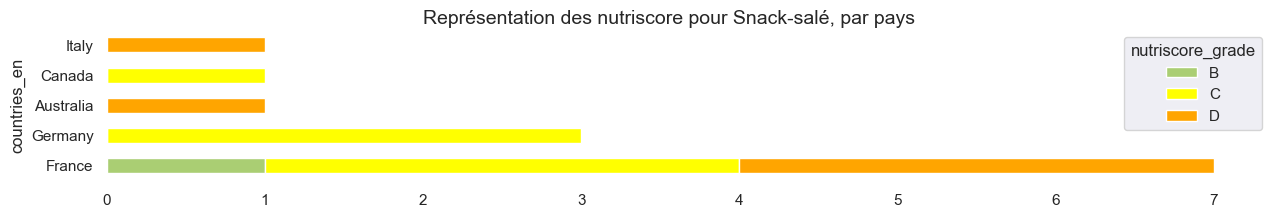

In [59]:
va_data.create_and_draw_nutriscore_group(salted_snack_light_brand_df, ['countries_en'], group_name='nutriscore_grade', title="Représentation des nutriscore pour Snack-salé, par pays")

(10, 4)


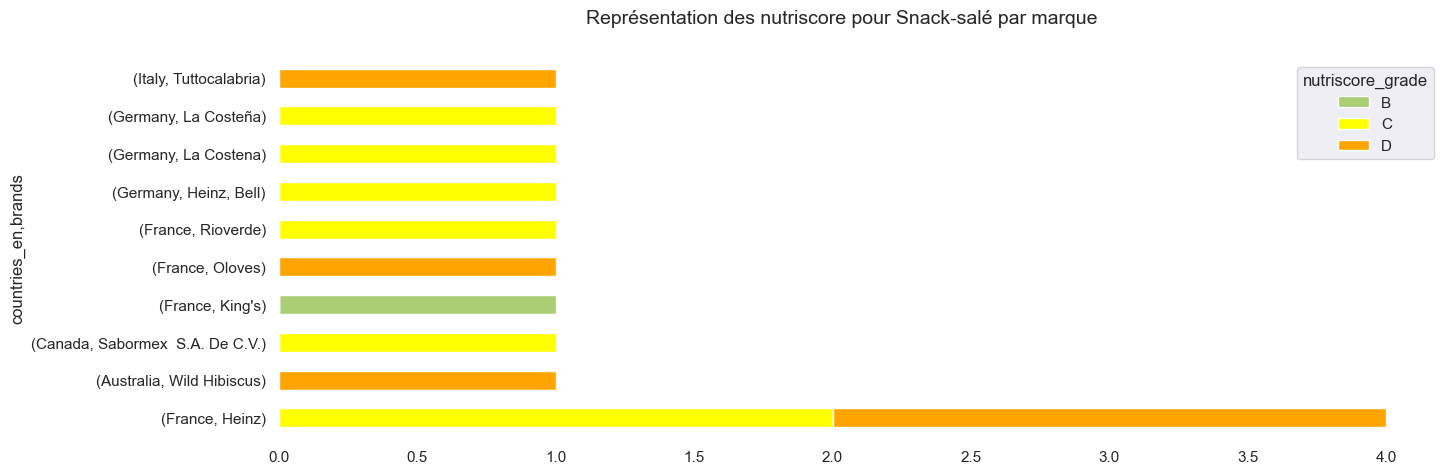

In [60]:
va_data.create_and_draw_nutriscore_group(salted_snack_light_brand_df, ['countries_en', 'brands'], group_name='nutriscore_grade', title="Représentation des nutriscore pour Snack-salé par marque")

<mark>Conclusion : Les concurrents ne sont pas au nutriscore maximum, il est donc possible de se démarquer avec un meilleur nutriscore</mark>

# <mark>3. Application - ETUDE DE MARCHE - Résumé</mark>

> 3) Élaborer une idée d’application. Identifier des arguments justifiant la faisabilité (ou non) de l’application à partir des données Open Food Facts.

Tout au long de notre analyse nous avons gardé le fil conducteur de notre scénario de départ (cf. debut de ce document)

Rappel :
* Application : Etude de marché
* Scénario : <mark> lancement d'un nouveau produit</mark>    
* Objectif du scénario : <mark>=> objectif avoir un produit de la même catégorie que les concurrent mais avec un meilleur nutriscore</mark>

Suite à l'analyse des données nutritionnelles existantes, à la répartition des marques et au marché internationnal, voici nos conclusions :

1. Type de produit : Snacks salés
1. Concurrences : forte aux Etats Unis, très limitée voir inexistante ailleurs
1. Développement à l'international : Fort potentiel de développement en Europe dans un premier temps, l'implantation aux Etats Unis risque d'être difficile au vu de l'implantation actuelle et du nombre de concurrents déjà sur le marché américain.
1. Facteur différenciant : possibilité de développer une catégorie saine : pommes séchées, chips de bettraves, chips de sarasin, ..., ce qui permettrait d'avoir :
    1. un nutriscore plus intéressant que les concurrents, ... 
    1. un atout marketing
    1. l'Europe est sensibles au nutriscore


----------------------
# ACP

Commenter à chaque étape avec les observations

1. centrer et réduire les données
1. calculer les composantes principales
1. afficher et interpréter les axes de corrélations sans NAA
1. afficher le nuage de point des composantes principales (au moins les 2 premières) et le cercle des corrélations (cercles avec les flêches des variables)
  * Afficher l'inertie associée à chacun des 2 axes. pour identifier le taux de données représenté
1. faire le graphe des éboulis des valeurs propres
  * on a tendance à ne pas considérer comme importants les axes dont l’inertie associée est inférieure à (100/p)% , car ils représentent moins de variabilité qu’une seule variable initiale. La valeur de (100/p)% est celle obtenue quand toutes les variables sont indépendantes deux à deux. Ce critère est appelé critère de Kaiser.

In [61]:
df.columns

Index(['code', 'creator', 'created_datetime', 'last_modified_datetime',
       'product_name', 'brands', 'brands_tags', 'categories_en',
       'countries_tags', 'countries_en', 'ingredients_text', 'additives_n',
       'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutriscore_score',
       'nutriscore_grade', 'nova_group', 'pnns_groups_1', 'pnns_groups_2',
       'main_category_en', 'energy-kj_100g', 'energy-kcal_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g',
       'fruits-vegetables-nuts-estimate-from-ingredients_100g',
       'nutrition-score-fr_100g', 'nutri_group', 'pnns_groups'],
      dtype='object')

In [62]:
df.describe(include="all")

C:\Users\User\AppData\Local\Temp/ipykernel_16208/1985922364.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include="all")


,code,creator,created_datetime,last_modified_datetime,product_name,brands,brands_tags,categories_en,countries_tags,countries_en,...,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g,nutri_group,pnns_groups
count,266232,266232,266232,266232,266232,190792,190789,226210,265875,265875,...,266232.000000,266232.000000,266232.000000,266232.000000,266232.000000,266232.000000,266232.000000,219937.000000,266232.000000,226210
unique,266232,4368,179696,186678,205552,50871,42316,19732,1432,1432,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3373
top,4058172761478,usda-ndb-import,2017-03-09 09:05:53+00:00,2020-11-14 15:15:34+00:00,Ice cream,Auchan,auchan,Snacks,en:united-states,United States,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Biscuits and cakes
freq,1,83207,19,46,683,2043,2111,13001,156836,156836,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26555
first,NaN,NaN,2012-02-15 22:02:08+00:00,2013-05-10 02:25:30+00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2021-11-15 18:51:31+00:00,2021-11-17 01:26:21+00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.336851,31.394975,9.508748,7.578040,0.826901,0.330763,0.039650,7.569190,2.494261,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.230548,27.097387,11.989731,6.266211,0.769110,0.307648,0.262756,8.510062,1.675391,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,6.400000,0.800000,3.000000,0.120000,0.048000,0.000000,0.000000,1.000000,NaN


In [63]:
numeric_columns_name = va_pre.get_numeric_columns_names(df)
# On supprime la colonne cible du calcul
numeric_columns_name.remove("nutrition-score-fr_100g")
numeric_columns_name.remove('product_name')
numeric_columns_name.remove('energy-kj_100g')     # iso kcal
numeric_columns_name.remove('sodium_100g')        # iso salt
numeric_columns_name.remove('saturated-fat_100g') # inclus dans fat
numeric_columns_name

['additives_n',
 'ingredients_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil_n',
 'energy-kcal_100g',
 'fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'proteins_100g',
 'salt_100g',
 'fruits-vegetables-nuts-estimate-from-ingredients_100g']

In [64]:
# selection des colonnes à prendre en compte dans l'ACP
df_centre_reduit = df.copy()
df_centre_reduit = df_centre_reduit[numeric_columns_name]
print("{:_} NAN".format(df_centre_reduit.isna().sum().sum()))

34 NAN


In [65]:
# reduire et centrer les donnees, pour ça il faut supprimer les NA
df_centre_reduit_no_na = df_centre_reduit.dropna()
print("{:_} NAN".format(df_centre_reduit_no_na.isna().sum().sum()))

0 NAN


<AxesSubplot:>

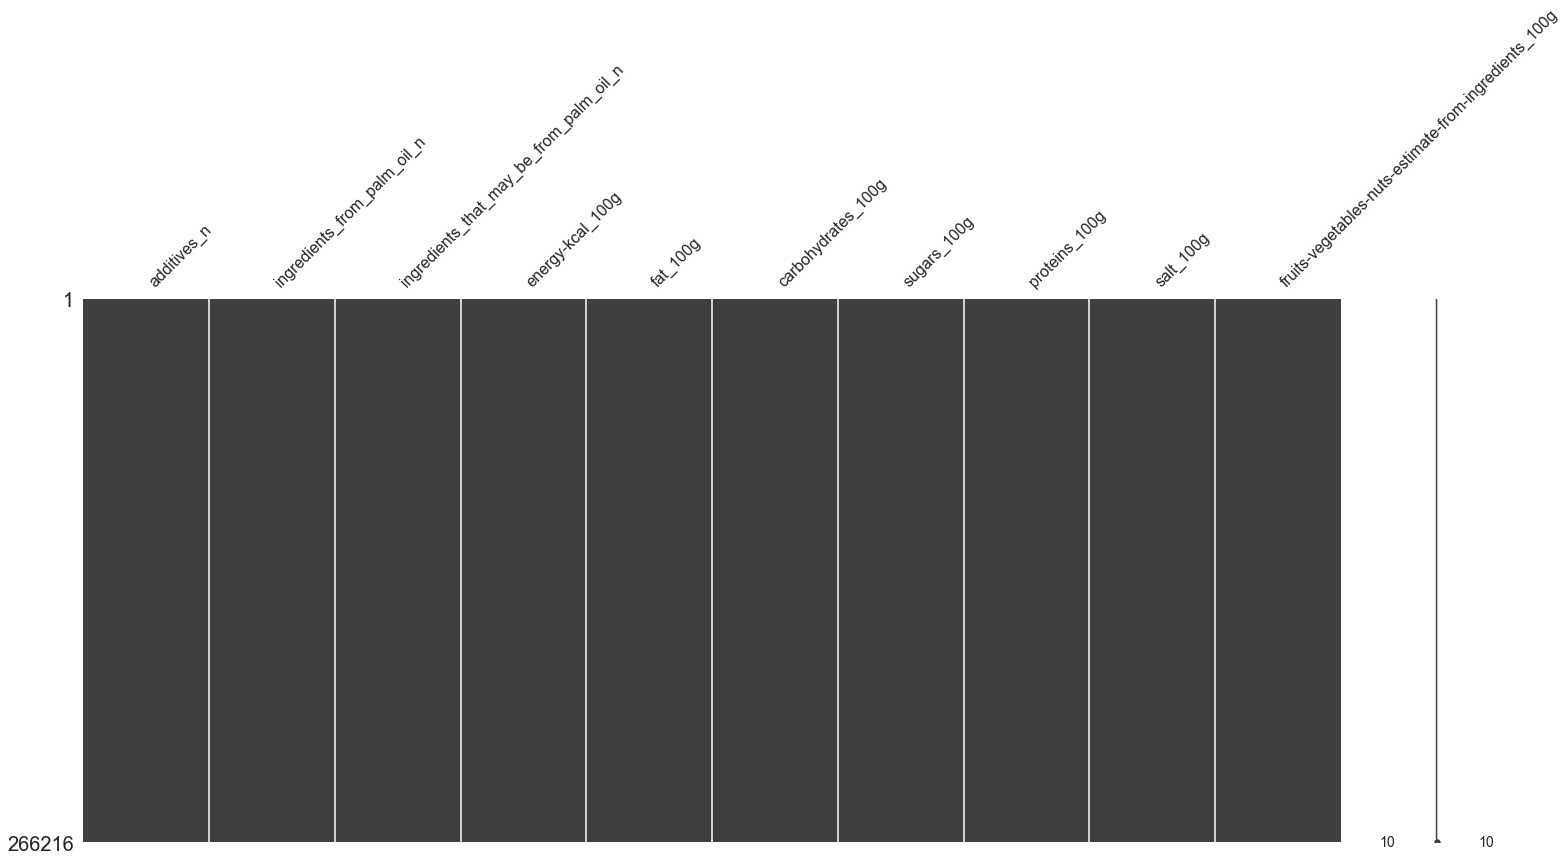

In [66]:
msno.matrix(df_centre_reduit_no_na)

<AxesSubplot:>

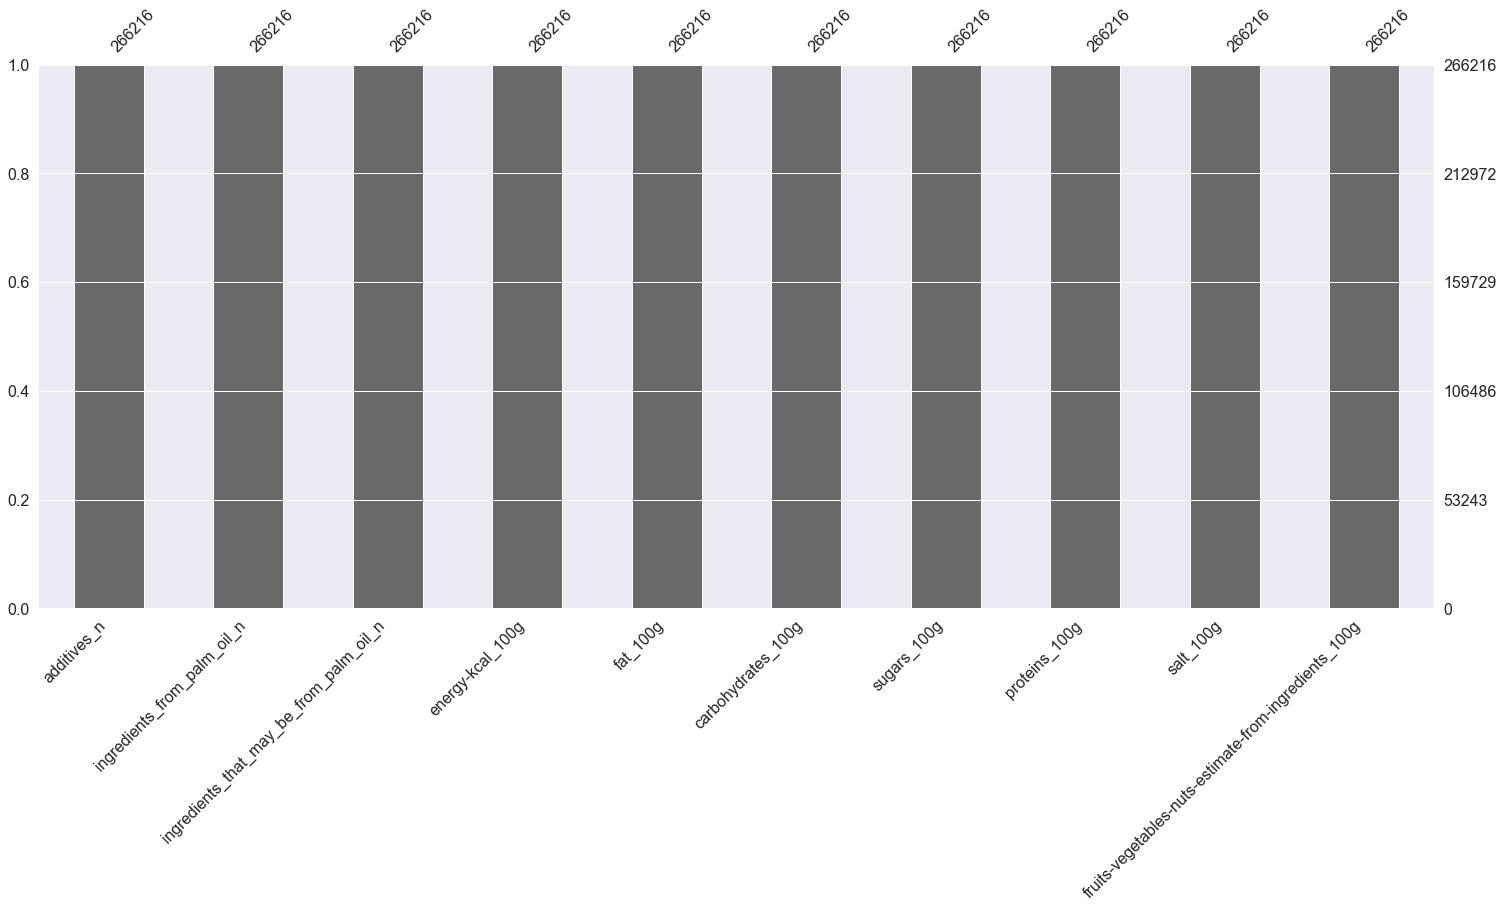

In [67]:
msno.bar(df_centre_reduit_no_na)

In [68]:
print(df_centre_reduit_no_na.shape, "( before:",df_centre_reduit.shape)

(266216, 10) ( before: (266232, 10)


In [69]:
# choix du nombre de composantes à calculer
ACP_NB_COMPOSANTES = len(numeric_columns_name)

# préparation des données pour l'ACP
X = df_centre_reduit_no_na.values
names = df_centre_reduit_no_na.index # ou data.index pour avoir les intitulés
features = df_centre_reduit_no_na.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# calculer les composantes principales
pca = decomposition.PCA(n_components=ACP_NB_COMPOSANTES)
x_projeected = pca.fit_transform(X_scaled)
pd.DataFrame(x_projeected, index=df_centre_reduit_no_na.index, columns=["F"+str(i+1) for i in range(ACP_NB_COMPOSANTES)])

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10
1,-1.441592,0.980347,-0.657936,0.123465,0.116891,-0.147231,0.483278,-0.100286,-0.333485,0.011650
2,-1.959378,-0.337195,-0.348525,0.197755,0.428322,0.616783,0.085504,0.969488,-0.349576,-0.002292
3,-2.247394,-0.050200,0.180075,-0.109865,0.122034,-0.519966,0.178635,-0.784104,-0.266500,-0.037698
4,1.259611,0.118147,-1.102454,0.019584,-0.103095,0.158530,-0.817297,-0.614514,-1.466380,0.059748
5,-1.255015,-0.016329,-0.607889,0.182299,0.267069,0.380816,-0.187679,-0.290993,0.275396,-0.006890
...,...,...,...,...,...,...,...,...,...,...
266227,-1.469856,-0.527425,-0.233442,0.171412,0.325600,0.155297,0.784264,0.478353,0.217473,0.015459
266228,-0.080644,-2.642425,0.270234,0.009966,0.313335,0.215516,0.508110,0.650987,-0.385052,-0.041761
266229,-0.080644,-2.642425,0.270234,0.009966,0.313335,0.215516,0.508110,0.650987,-0.385052,-0.041761
266230,1.228884,-2.313036,-0.037999,0.011461,0.235746,0.493056,0.871873,1.947470,-0.275733,-0.339553


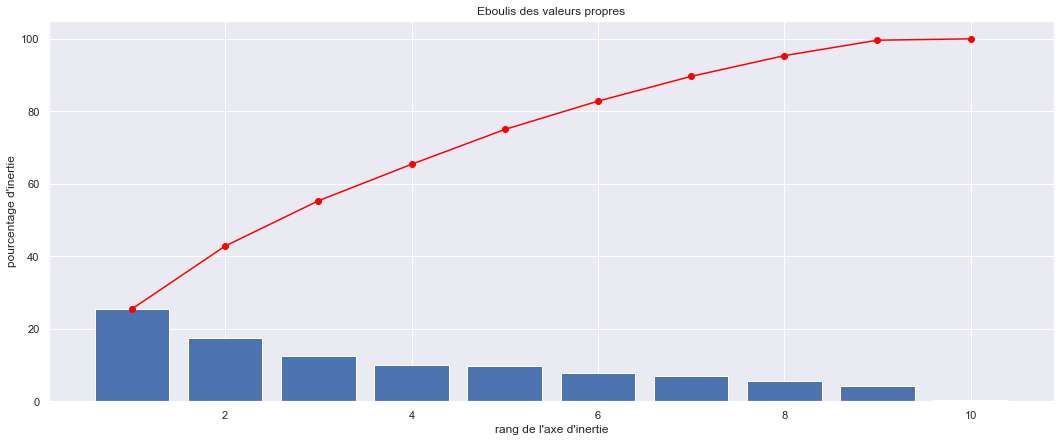

In [70]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=ACP_NB_COMPOSANTES)
pca.fit(X_scaled)

# Eboulis des valeurs propres
va_data.display_scree_plot(pca)

Par rapport à ce graphe, nous décidons de fixer le nombre de composantes pour atteindre minimum 80 %, soit 6 composantes.   
Nous modifions donc le nombre de composantes et refaisons les graphes en conséquence

In [71]:
df_centre_reduit_no_na.head()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy-kcal_100g,fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
1,0.0,0.0,0.0,106.000000,2.700000,17.400000,12.500000,2.200000,0.100000,0.0
2,0.0,0.0,0.0,72.000000,0.200000,4.100000,4.100000,13.500000,0.100000,0.0
3,0.0,0.0,0.0,20.000000,2.000000,0.000000,0.000000,2.000000,1.000000,0.0
4,0.0,0.0,0.0,342.000000,5.000000,63.000000,28.300000,8.700000,1.575000,0.0
5,0.0,0.0,0.0,163.636364,1.363636,30.909091,0.454545,6.818182,0.477273,0.0


In [72]:
# choix du nombre de composantes à calculer
ACP_NB_COMPOSANTES = 6
axis_ranks = [(0,1),(2,3),(4,5)]

Suite à la première génération, nous avons constaté que le graphe était peu lisible.
Nous avons généré le graphe par nutriscore pour mieux voir la projection des individus

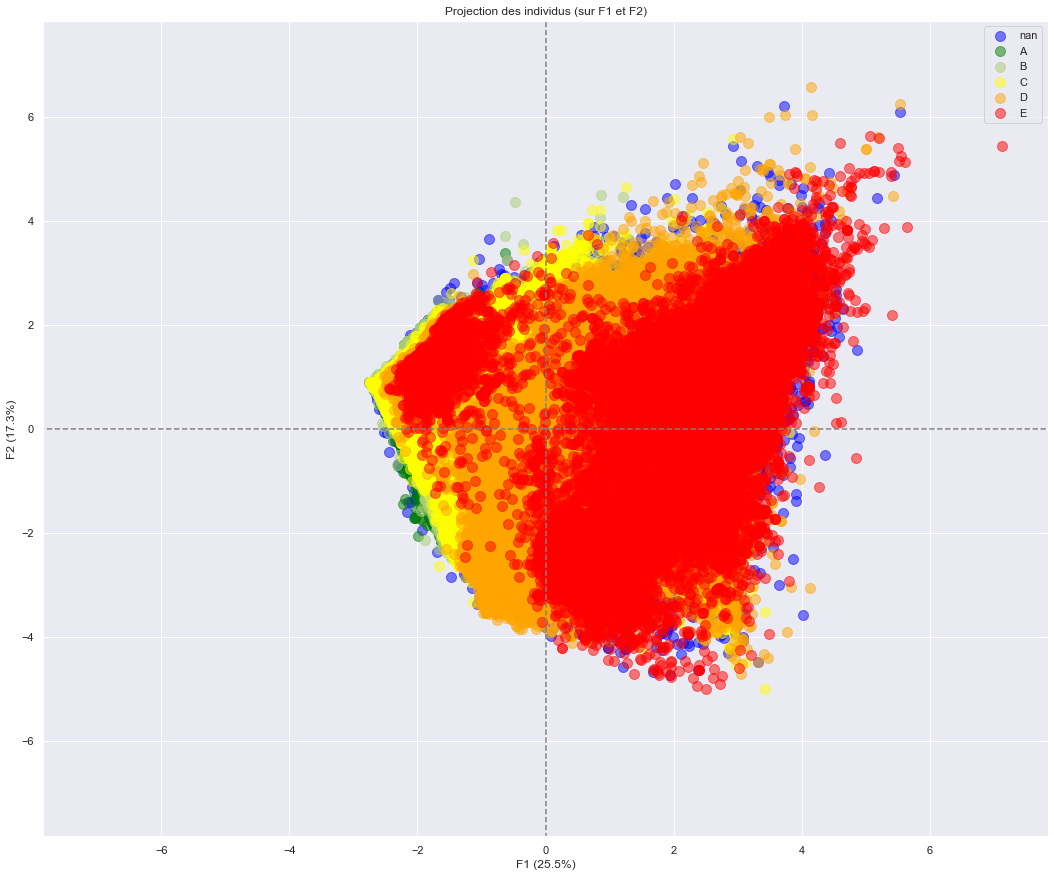

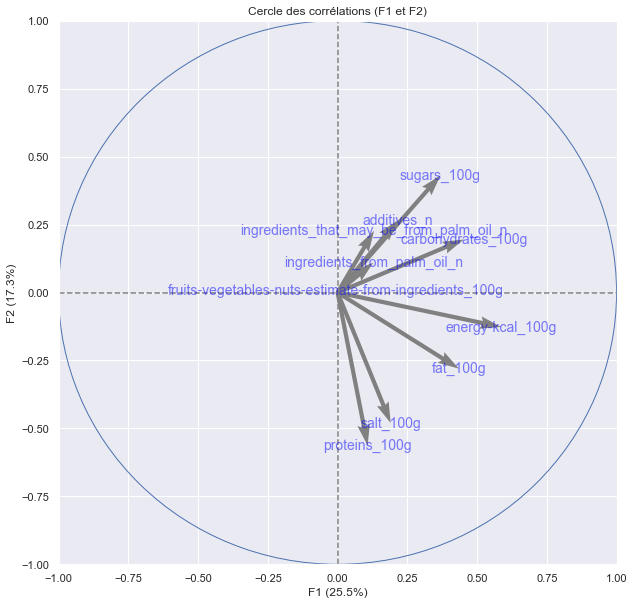

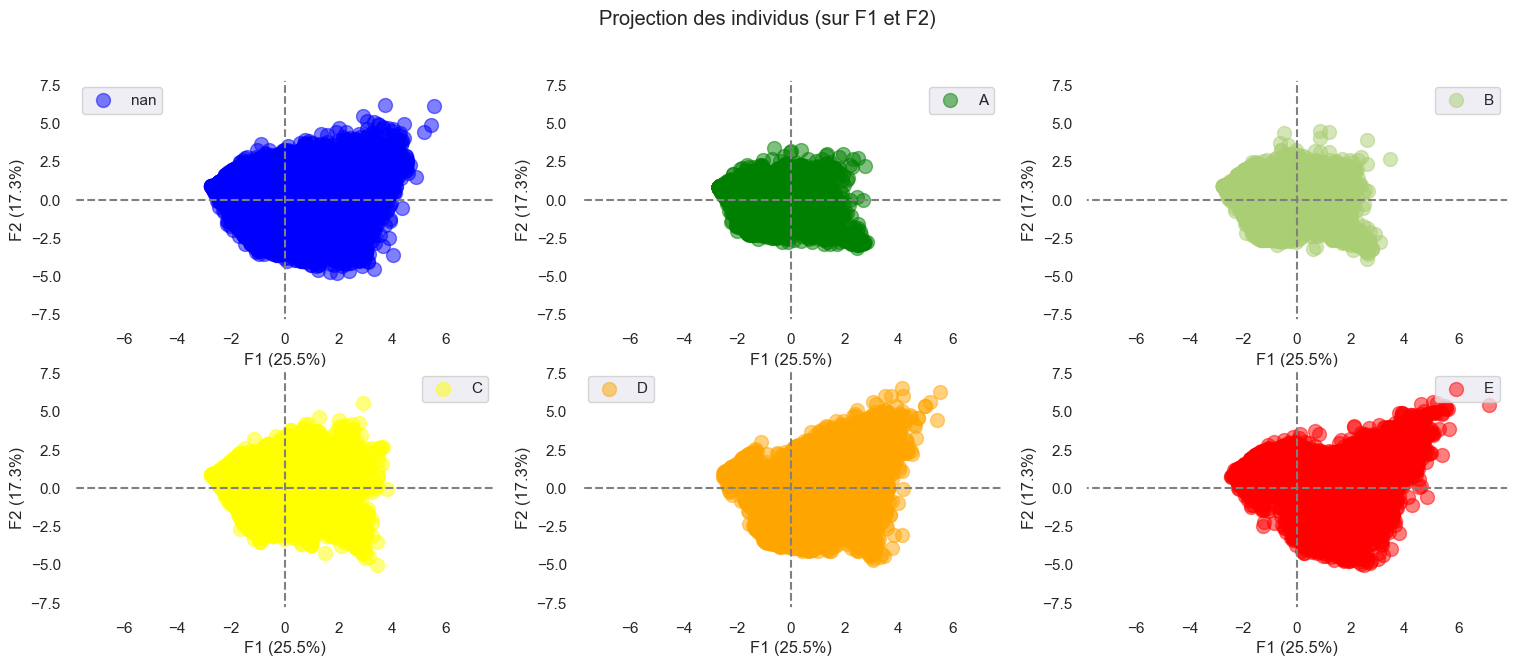

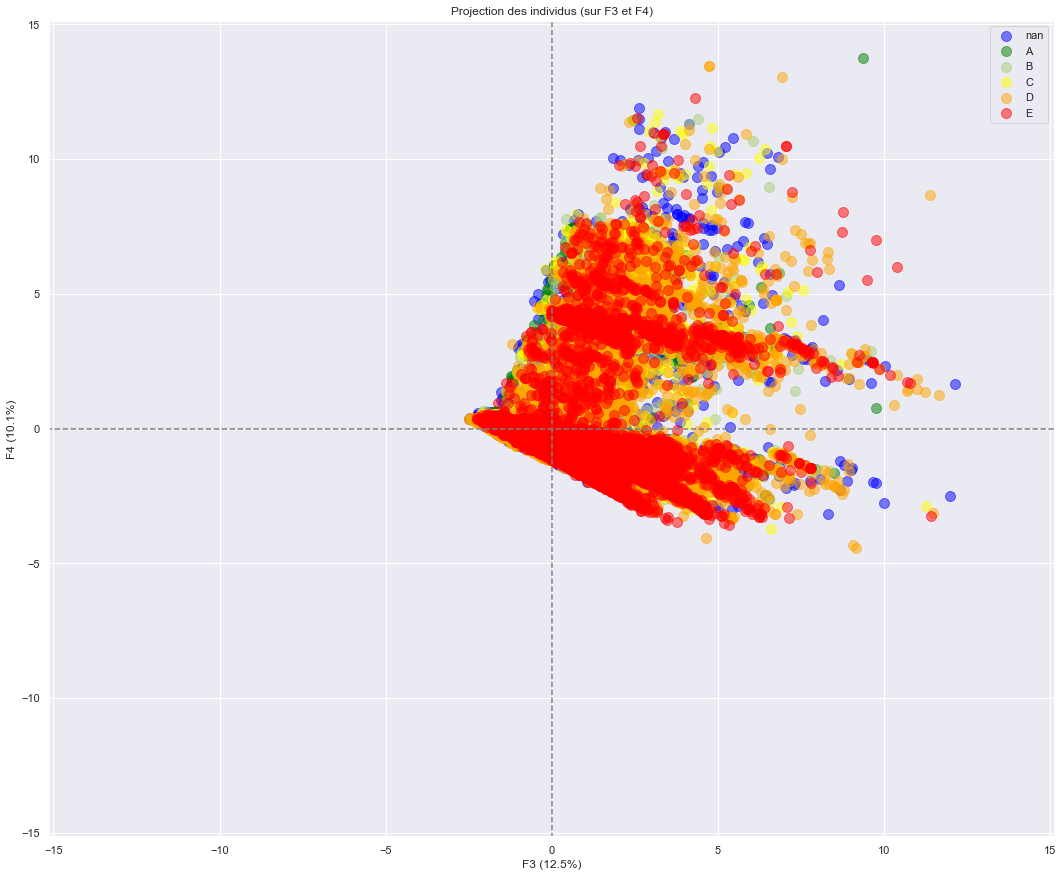

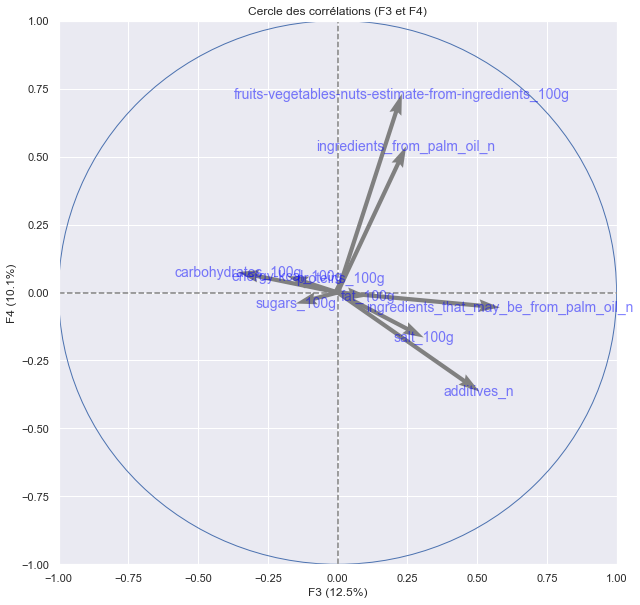

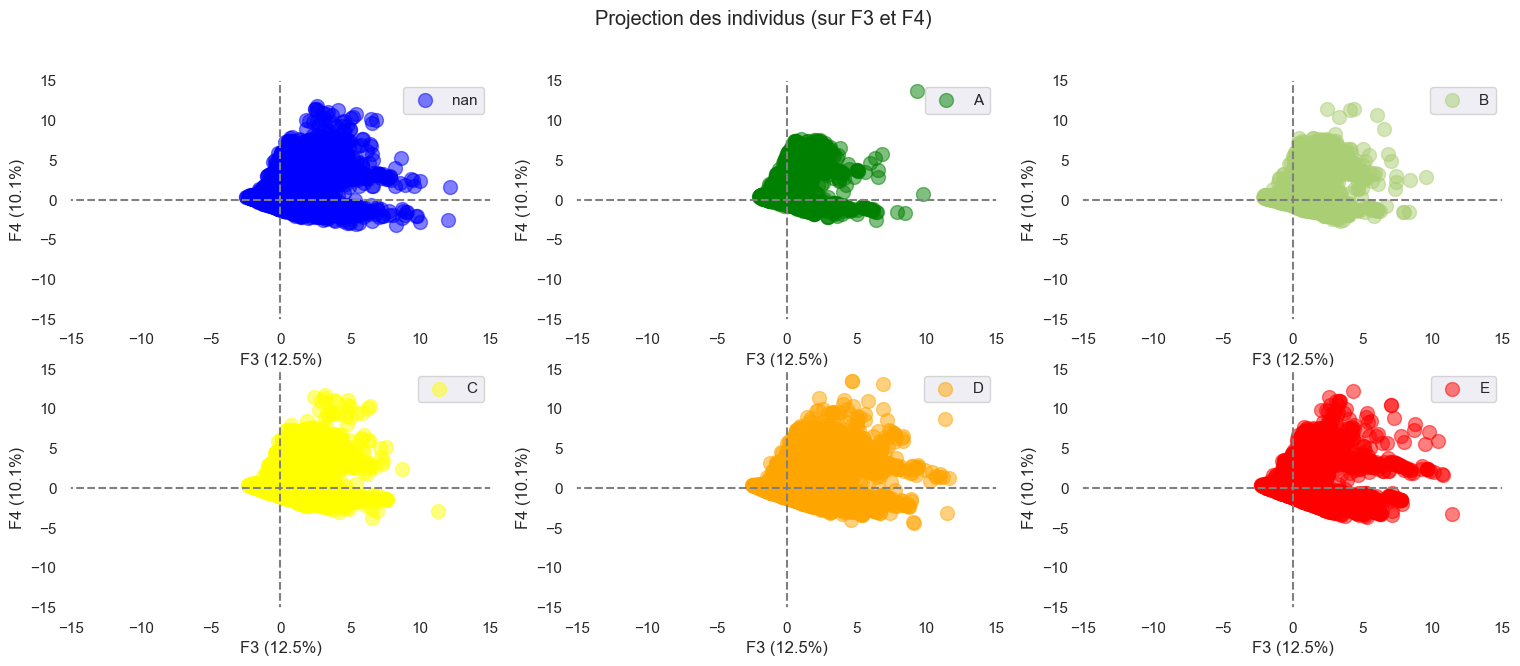

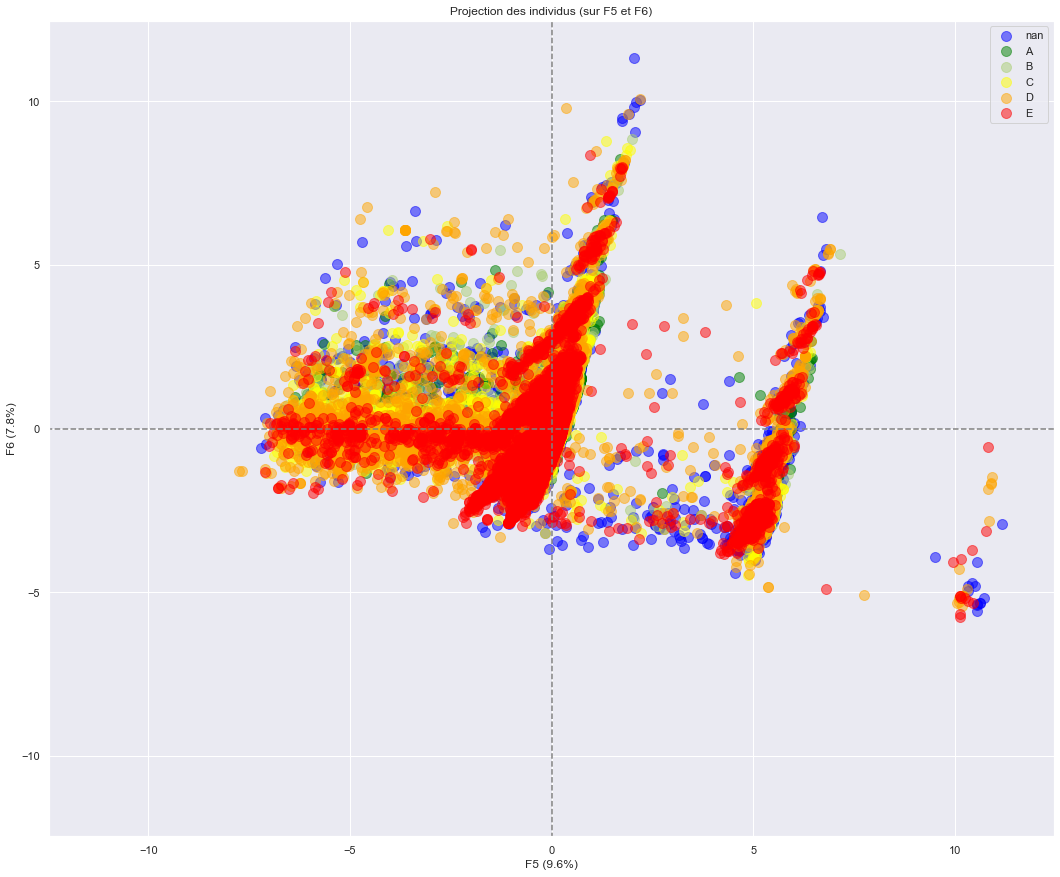

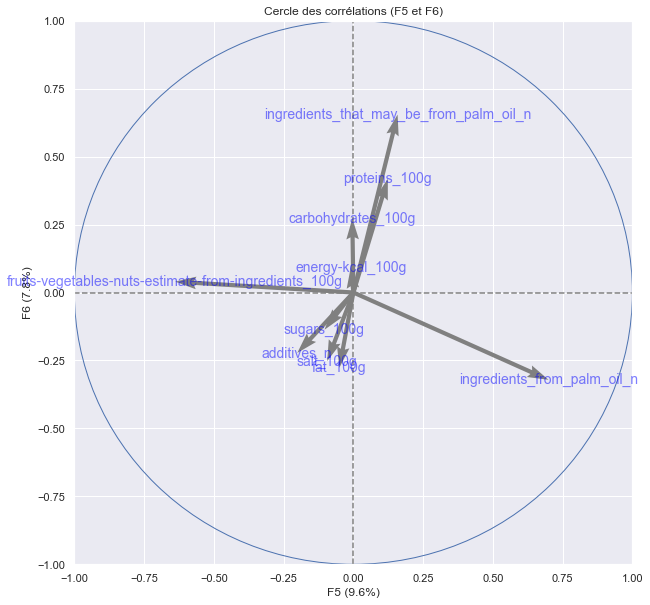

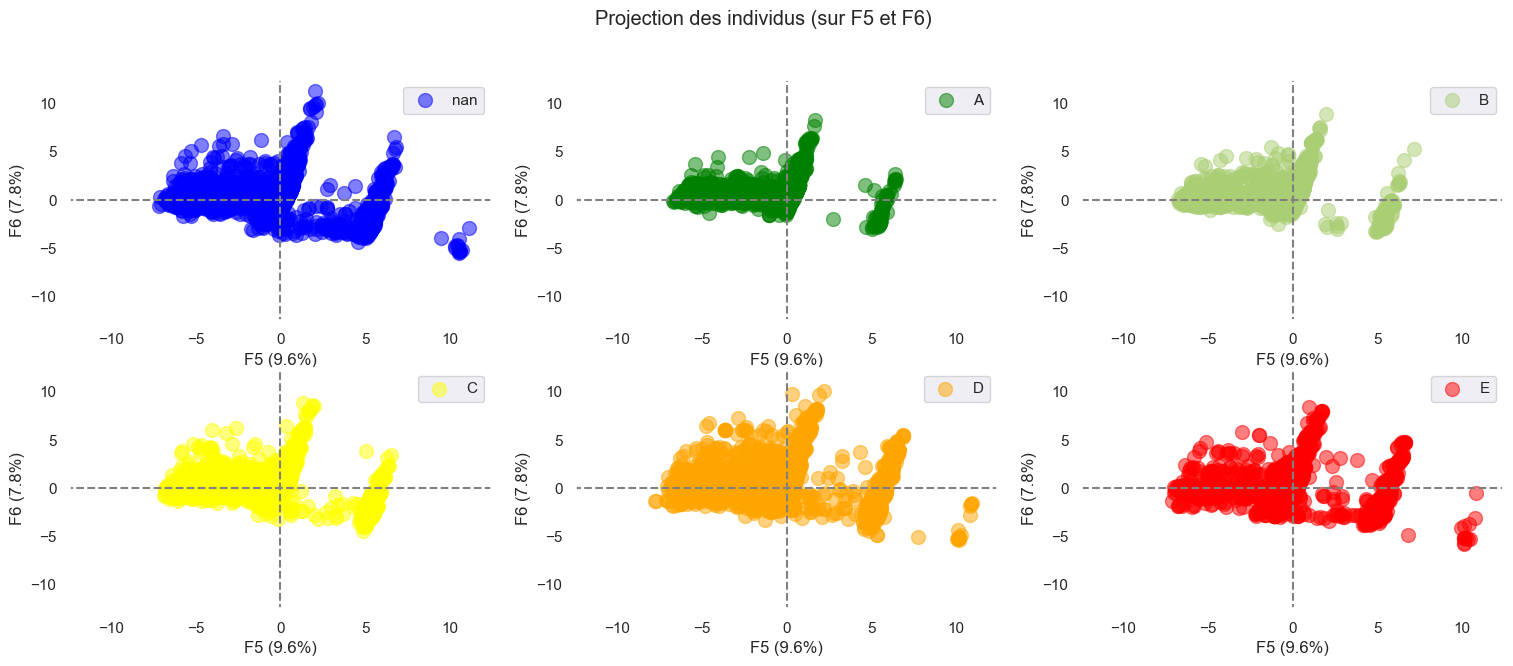

In [73]:
# Projection des individus
X_projected = pca.transform(X_scaled)
pcs = pca.components_

# Theme du ou des parcours auxquels appartient le cours (data, developpement, marketing, etc.)
theme = [df.loc[index, "nutriscore_grade"] for index in df_centre_reduit_no_na.index]

for rank in axis_ranks:
    # Projection des individus
    va_data.display_factorial_planes(X_projected, ACP_NB_COMPOSANTES, pca, [rank], illustrative_var = theme)
    # Cercle des corrélations
    va_data.display_circles(pcs, ACP_NB_COMPOSANTES, pca, [rank], labels = np.array(features))
    va_data.display_factorial_planes_by_theme(X_projected, pca, ACP_NB_COMPOSANTES, [rank], illustrative_var = theme, by_theme=True)

## ACP : Commentaires

L'observation de la projection des individus avec les composantes principales F1 et F2 fait apparaître que :
* les individus de nutriscore A et B sont essentiellement concentrés au centre du graphe
* les individus de nutriscore D et E sont Gras et/ou Sucré et caloriques
